
TabNet Performance-Optimized Implementation


TABNET PERFORMANCE-OPTIMIZED EXPERIMENT

DATA LOADING & PREPROCESSING
Found dataset: data.csv
Loaded dataset: (569, 31)
Features: 30, Samples: 569
Class distribution: Benign=212 (37.3%), Malignant=357 (62.7%)

Using StandardScaler
Train: 455, Test: 114

PHASE 1: HYPERPARAMETER OPTIMIZATION
   SMOTE applied: 364 to 456 samples

PERFORMANCE-OPTIMIZED HYPERPARAMETER SEARCH
Running 200 trials...
Search space: n_d/n_a=[32-256], n_steps=[4-10], lr=[0.005-0.03]


  0%|          | 0/200 [00:00<?, ?it/s]


Early stopping occurred at epoch 55 with best_epoch = 25 and best_val_accuracy = 0.96703

Early stopping occurred at epoch 40 with best_epoch = 10 and best_val_accuracy = 0.93407

Early stopping occurred at epoch 57 with best_epoch = 27 and best_val_accuracy = 0.96703

Early stopping occurred at epoch 79 with best_epoch = 49 and best_val_accuracy = 0.96703

Early stopping occurred at epoch 34 with best_epoch = 4 and best_val_accuracy = 0.95604

Early stopping occurred at epoch 60 with best_epoch = 30 and best_val_accuracy = 0.96703

Early stopping occurred at epoch 52 with best_epoch = 22 and best_val_accuracy = 0.94505

Early stopping occurred at epoch 52 with best_epoch = 22 and best_val_accuracy = 0.94505

Early stopping occurred at epoch 57 with best_epoch = 27 and best_val_accuracy = 0.96703

Early stopping occurred at epoch 37 with best_epoch = 7 and best_val_accuracy = 0.93407

Early stopping occurred at epoch 48 with best_epoch = 18 and best_val_accuracy = 0.96703

Early stopp

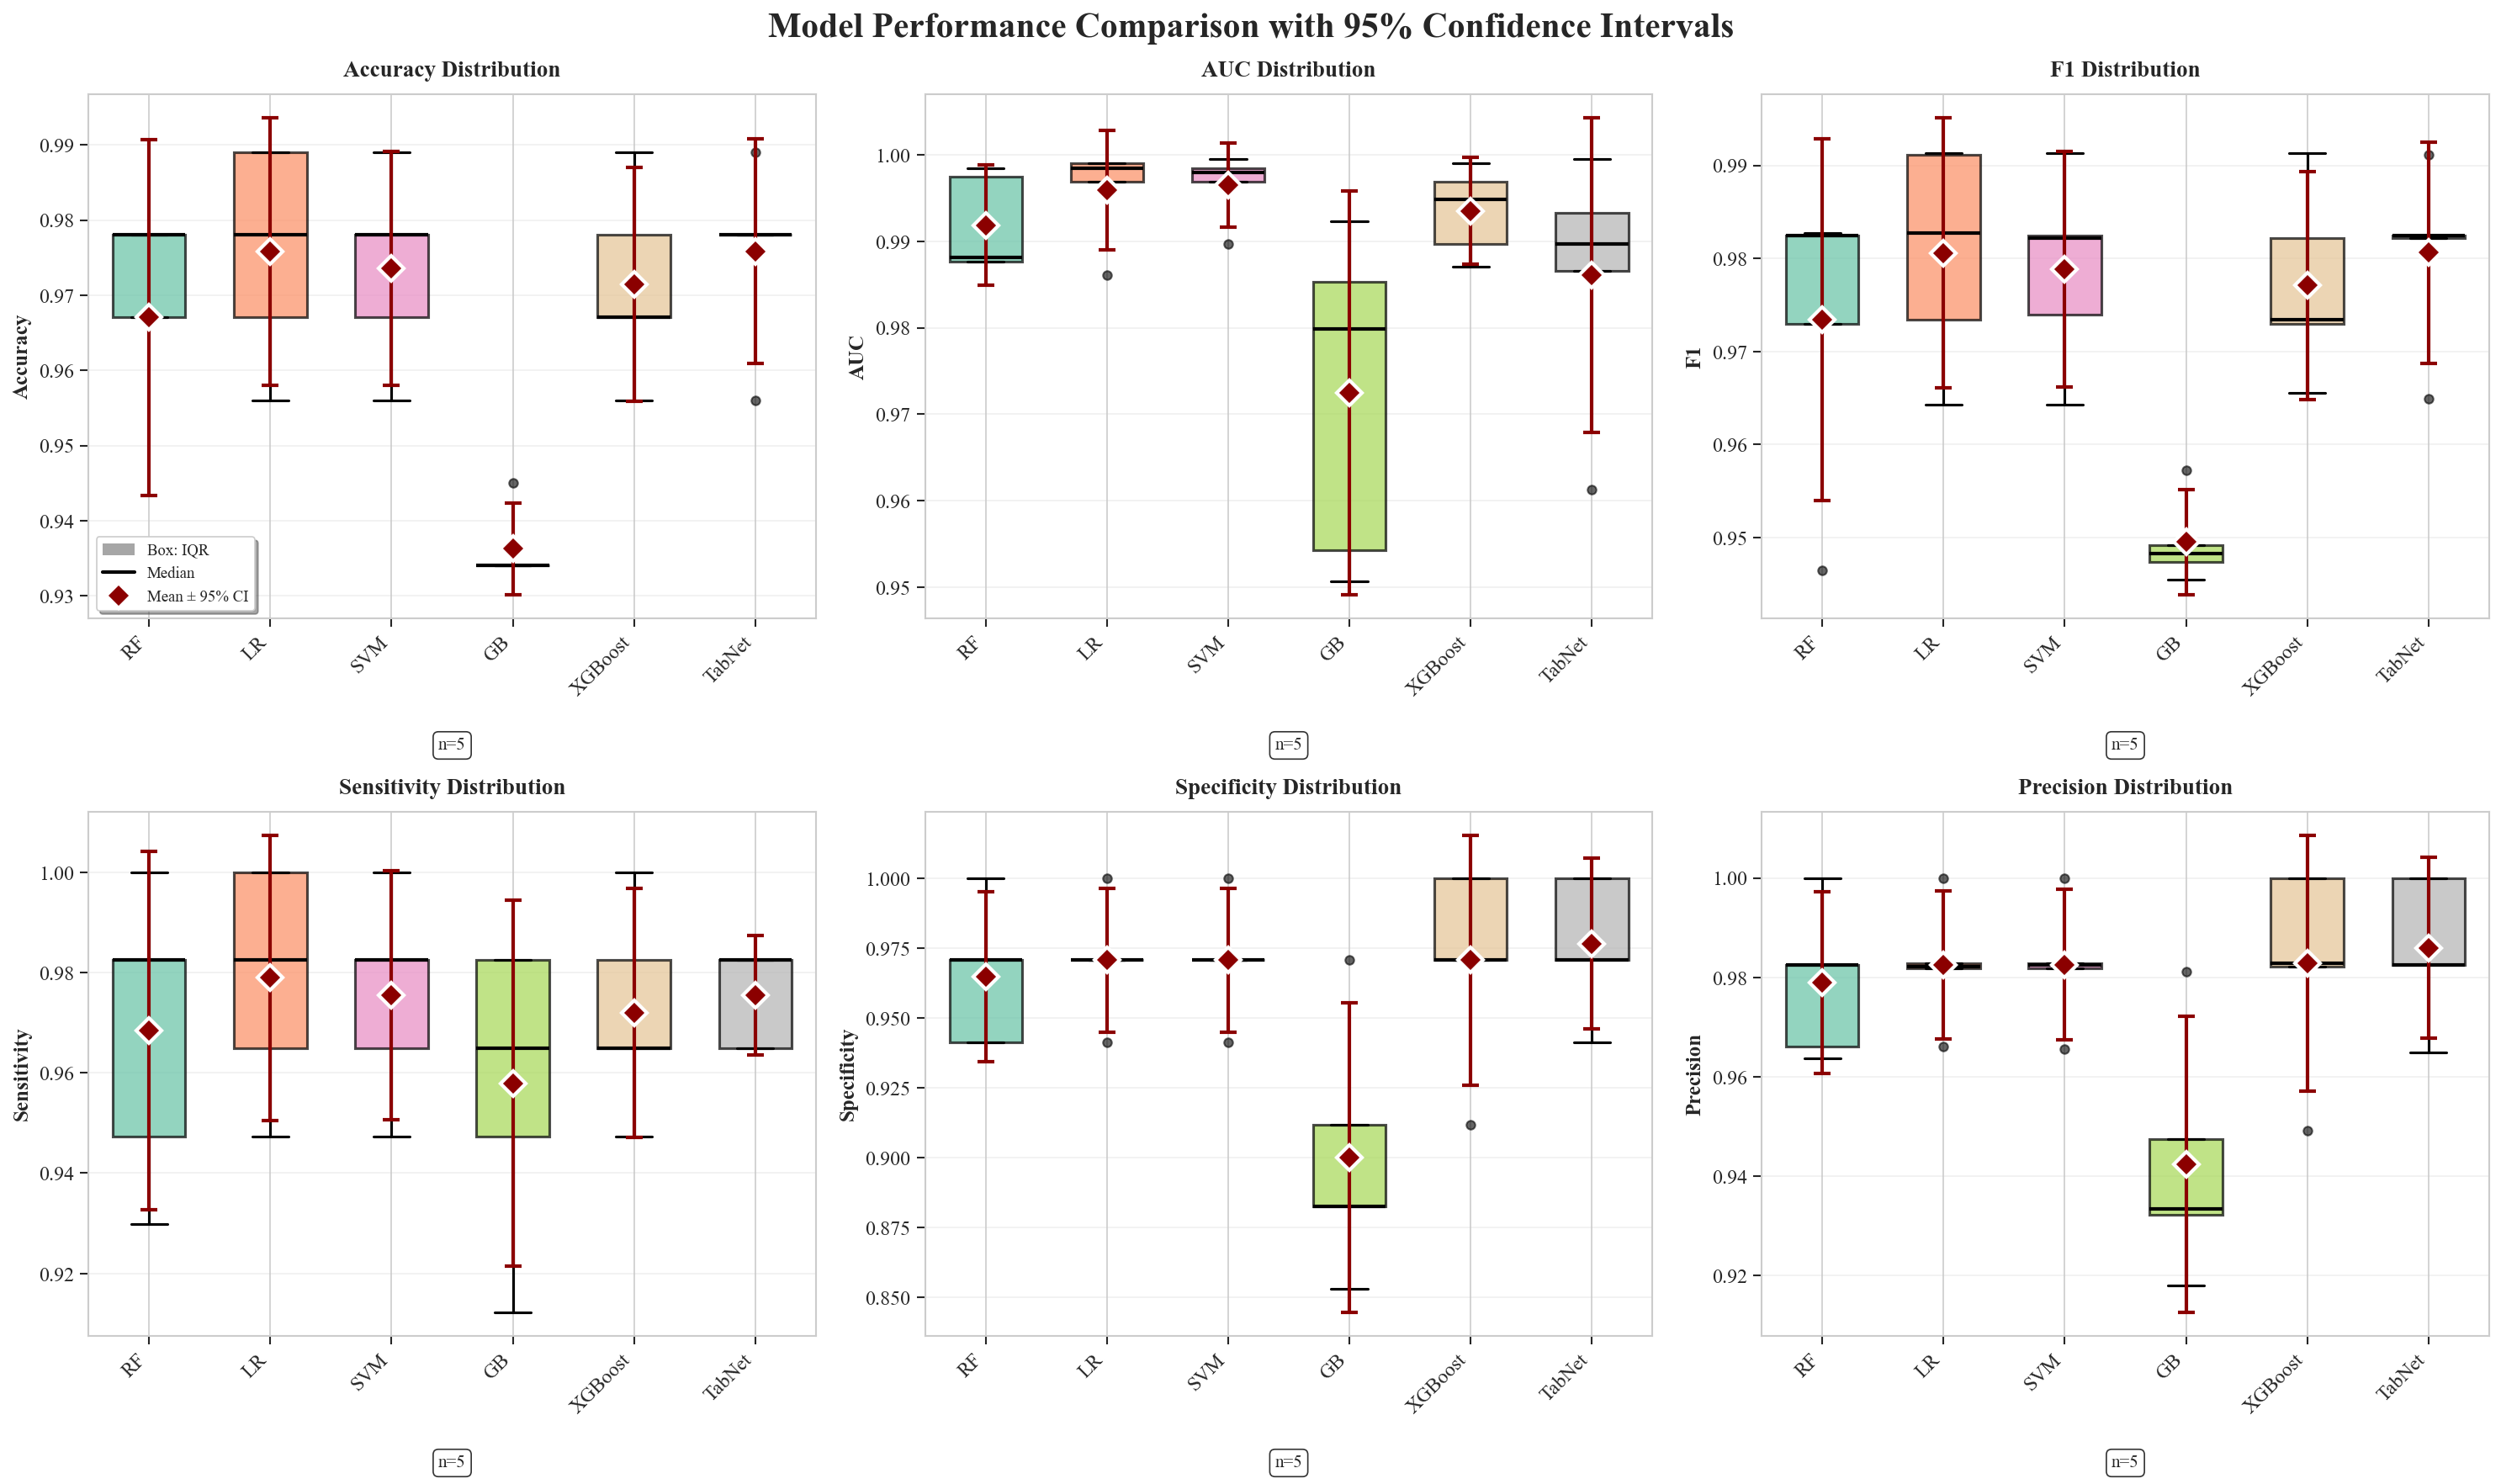


Generating Optuna optimization plots...
Saved: tabnet_performance_results\figure_02_optuna_optimization.png


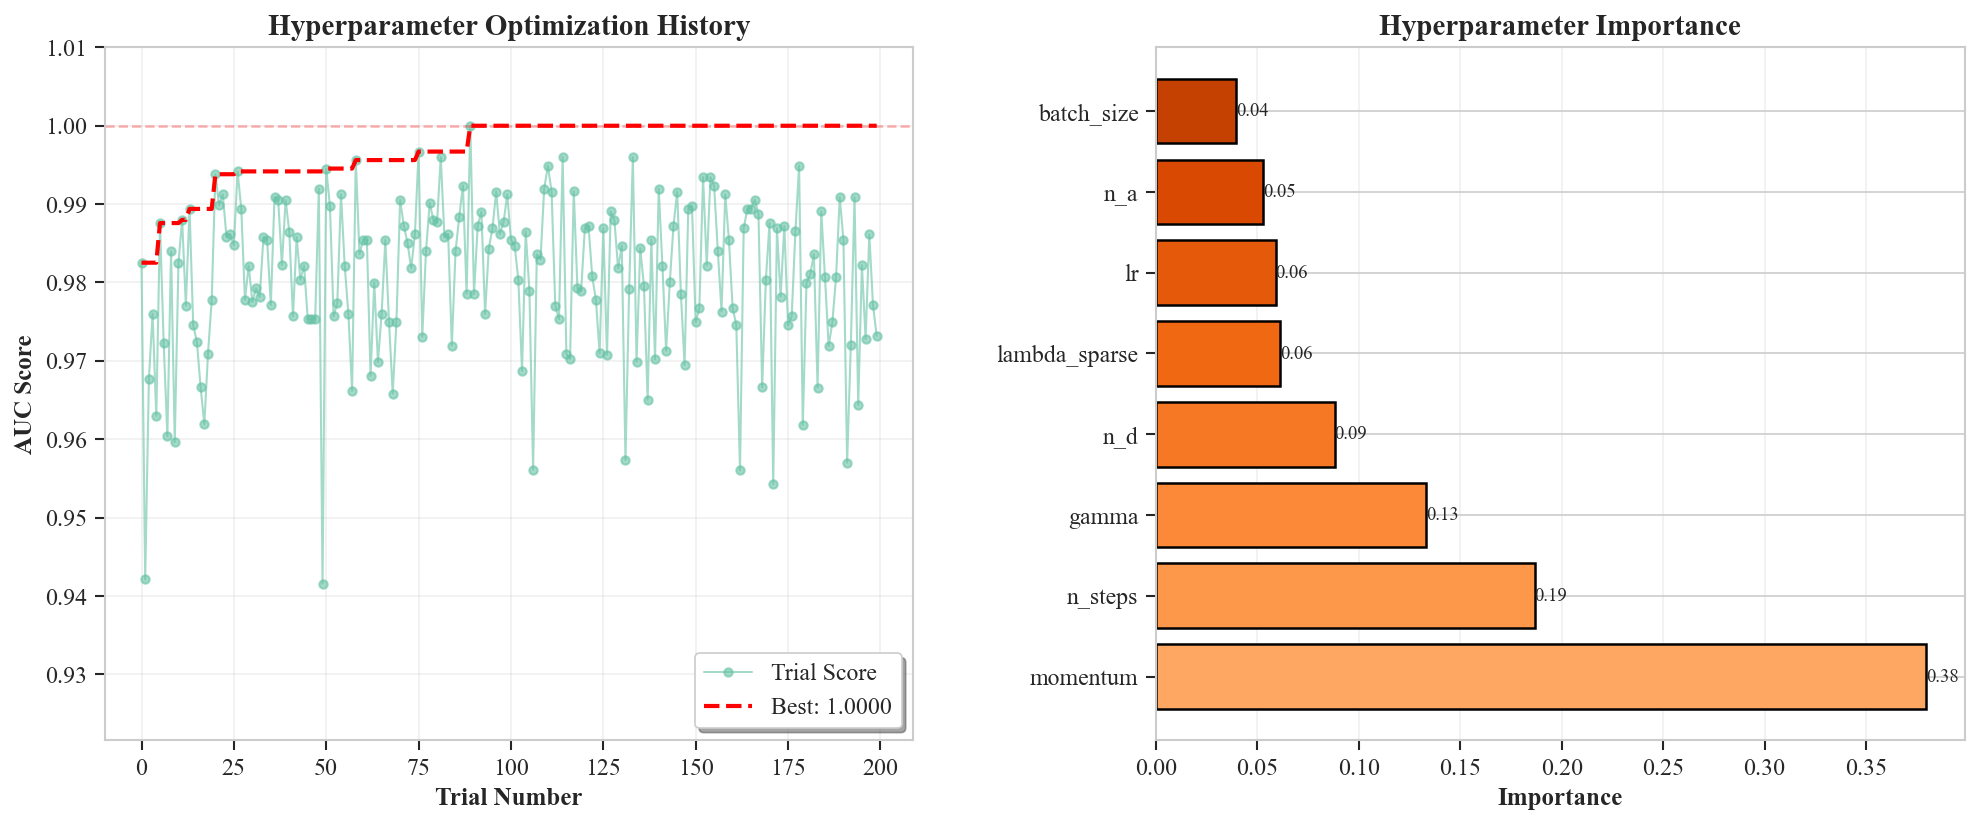


Generating training vs validation performance plot...
Saved: tabnet_performance_results\figure_03_train_val_performance.png


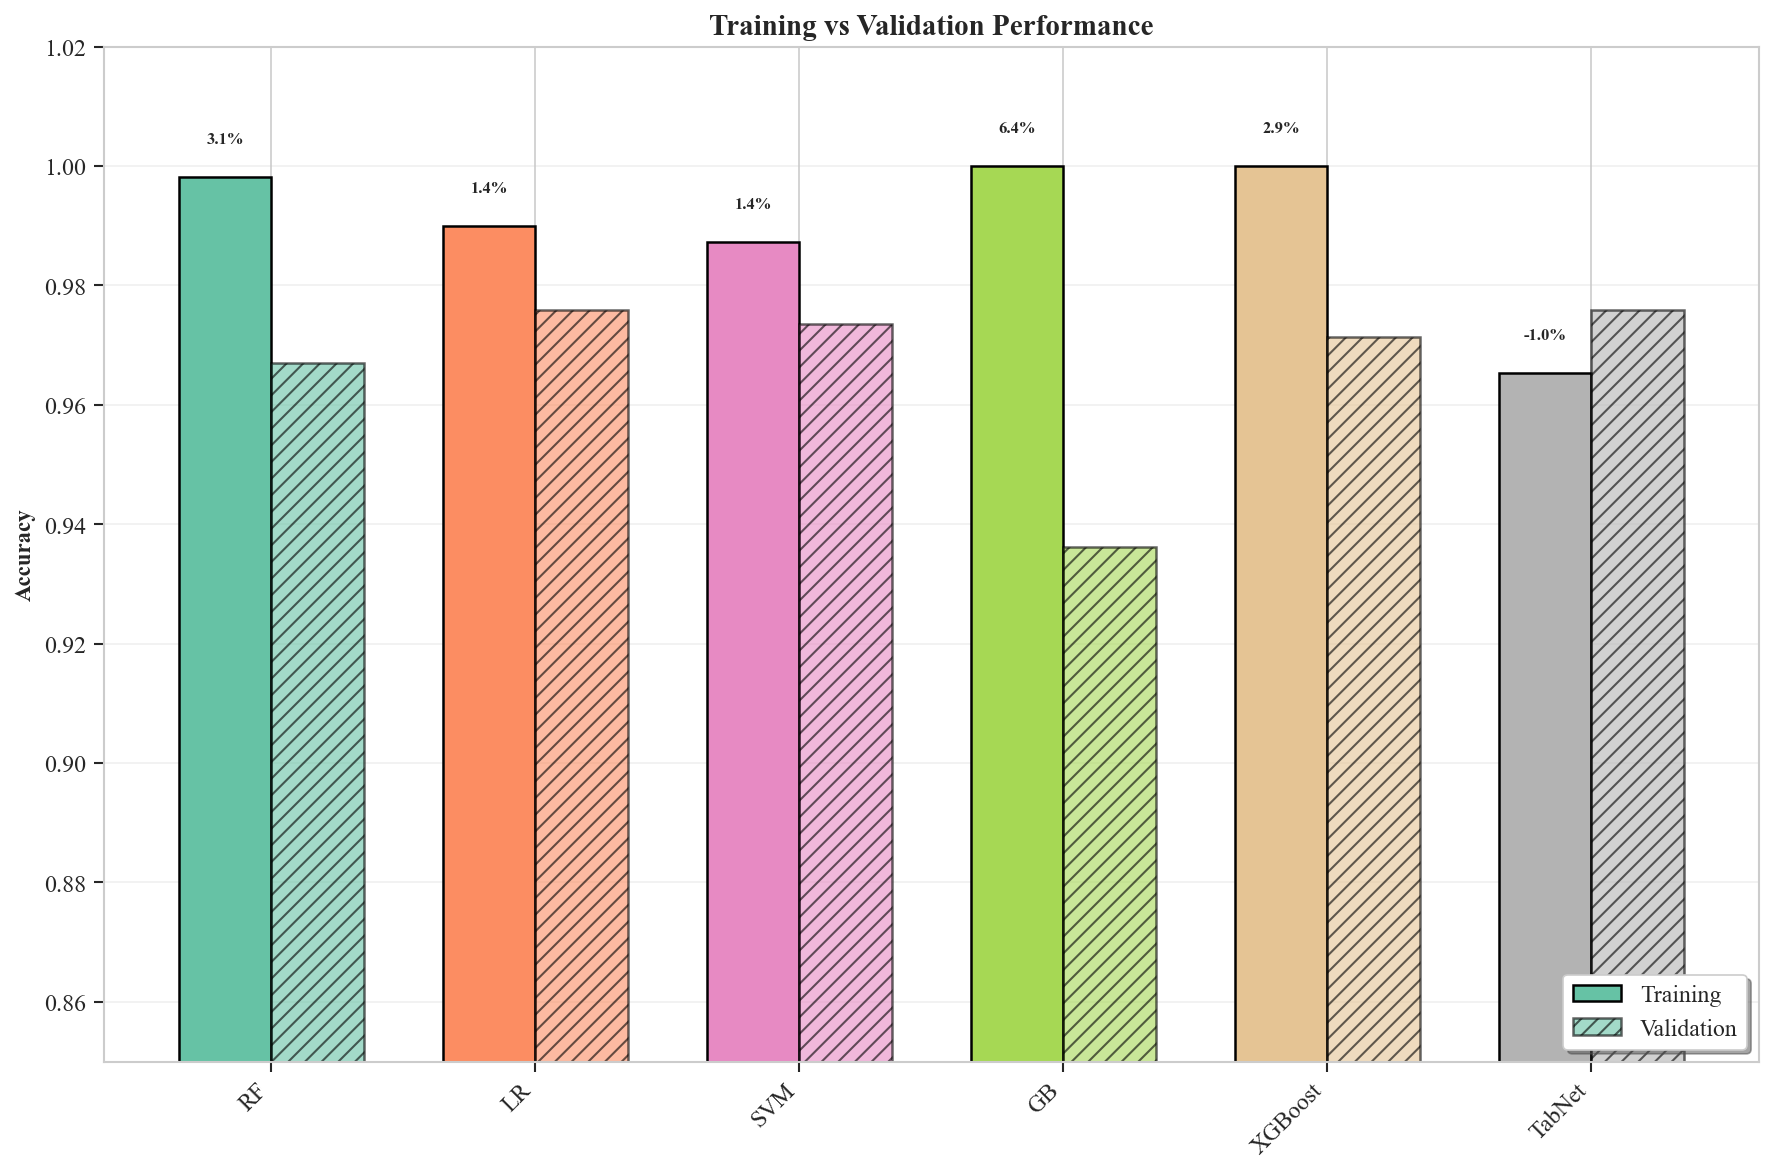


Generating metric variance plot...
Saved: tabnet_performance_results\figure_04_metric_variance.png


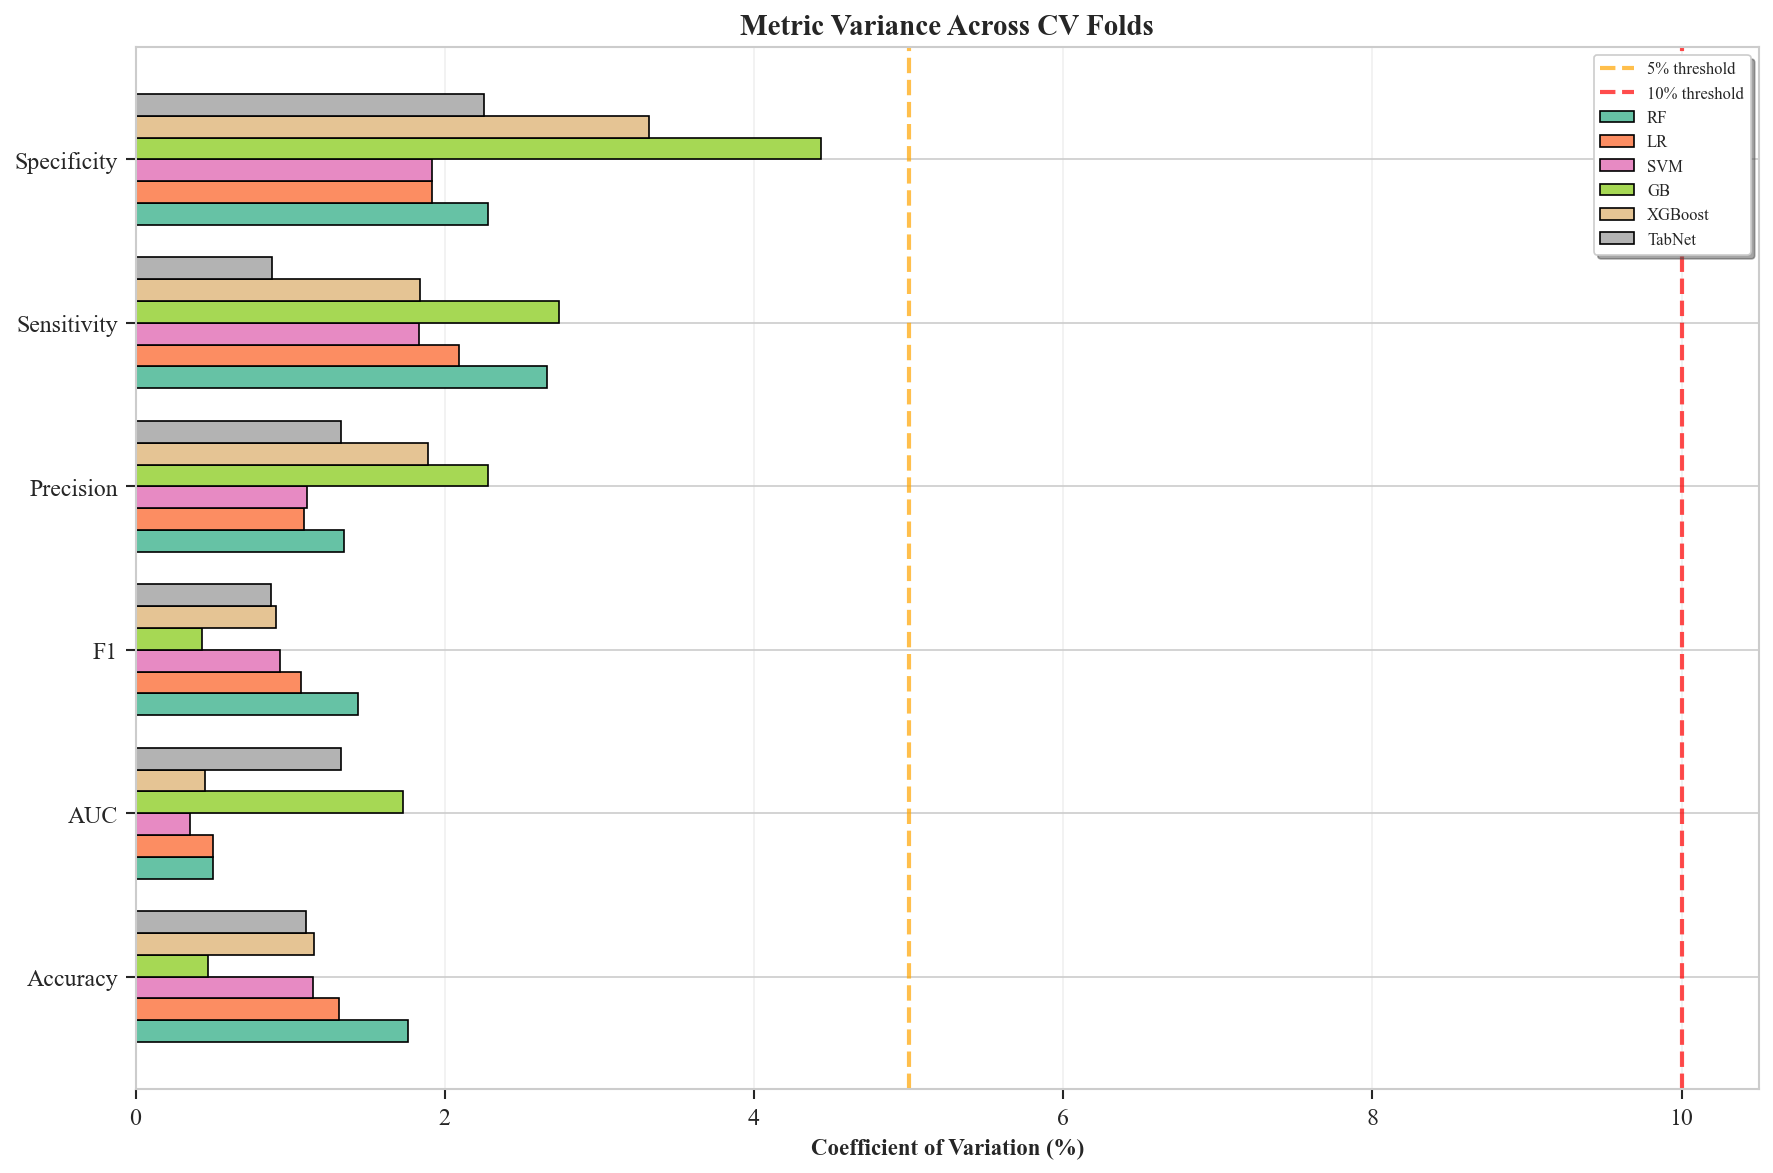


Generating accuracy distribution plot...
Saved: tabnet_performance_results\figure_05_accuracy_distribution.png


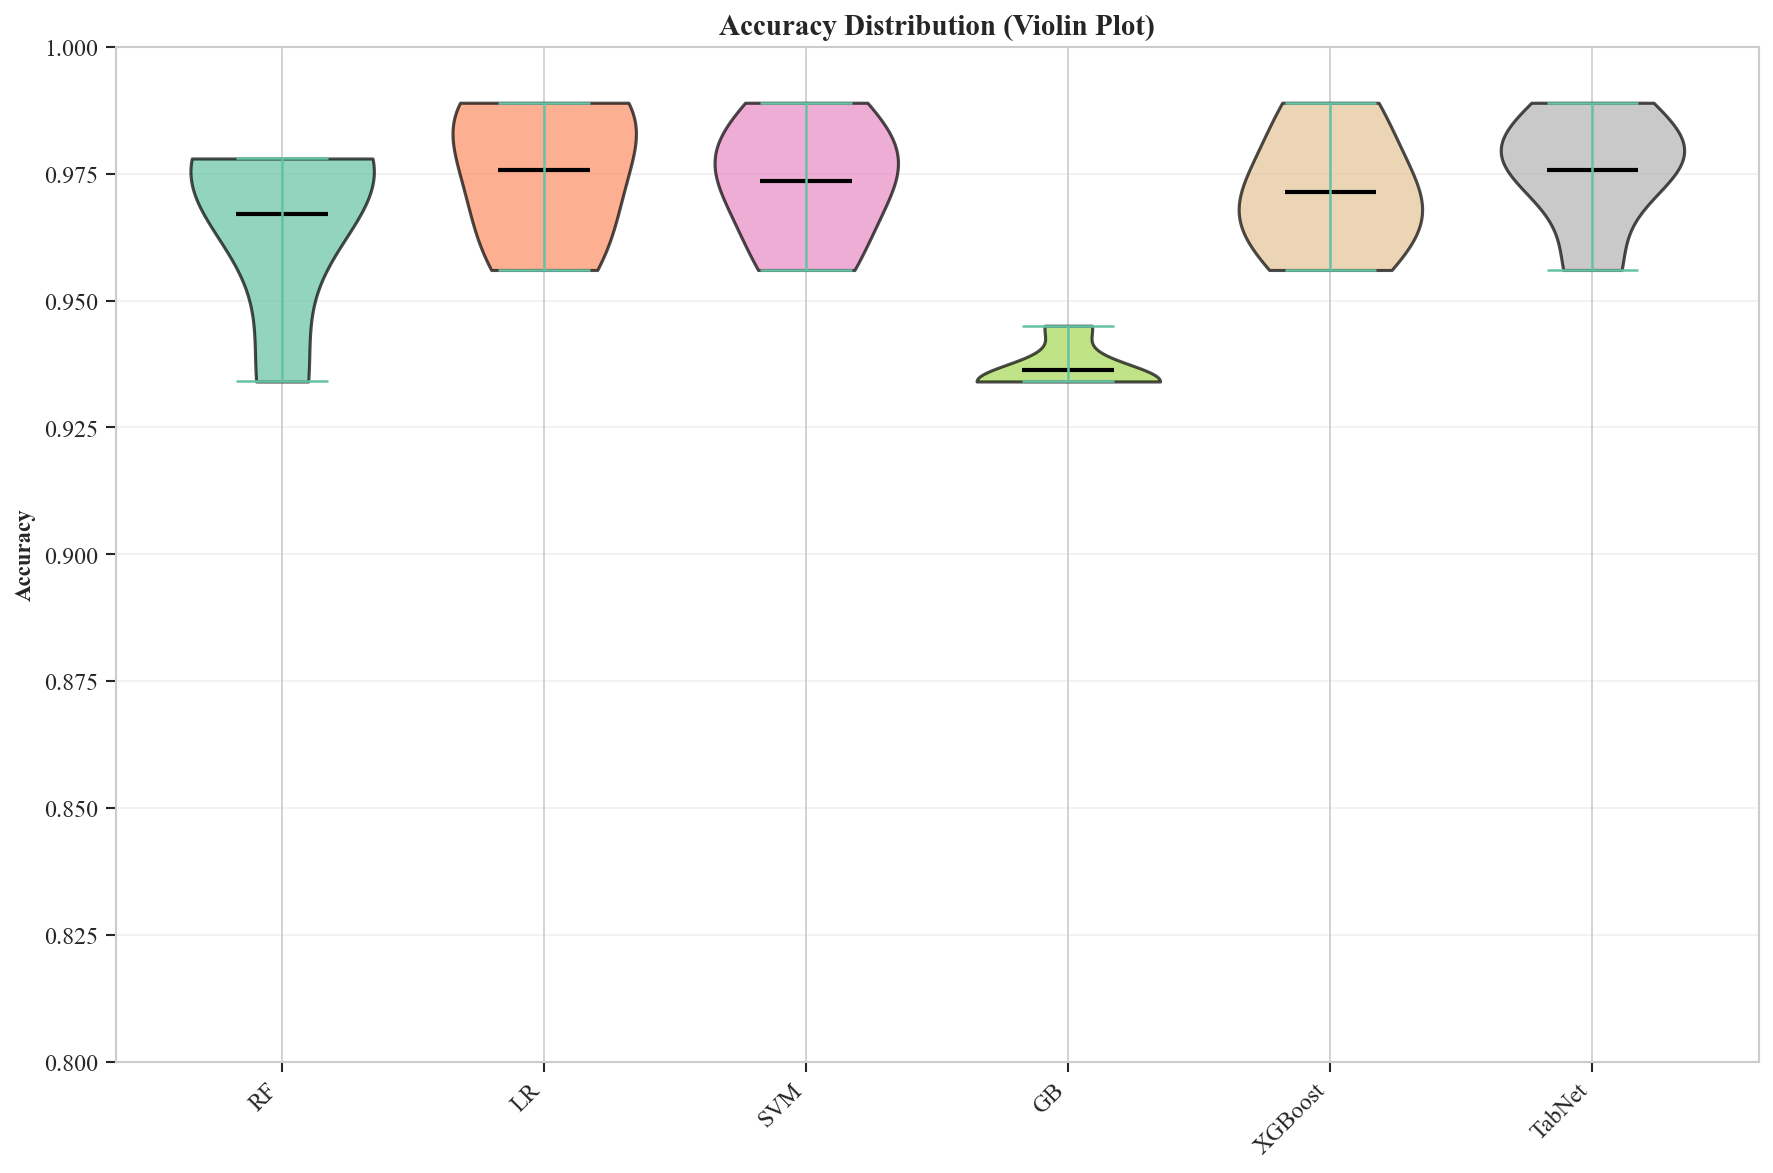


Generating gap heatmap...
Saved: tabnet_performance_results\figure_06_gap_heatmap.png


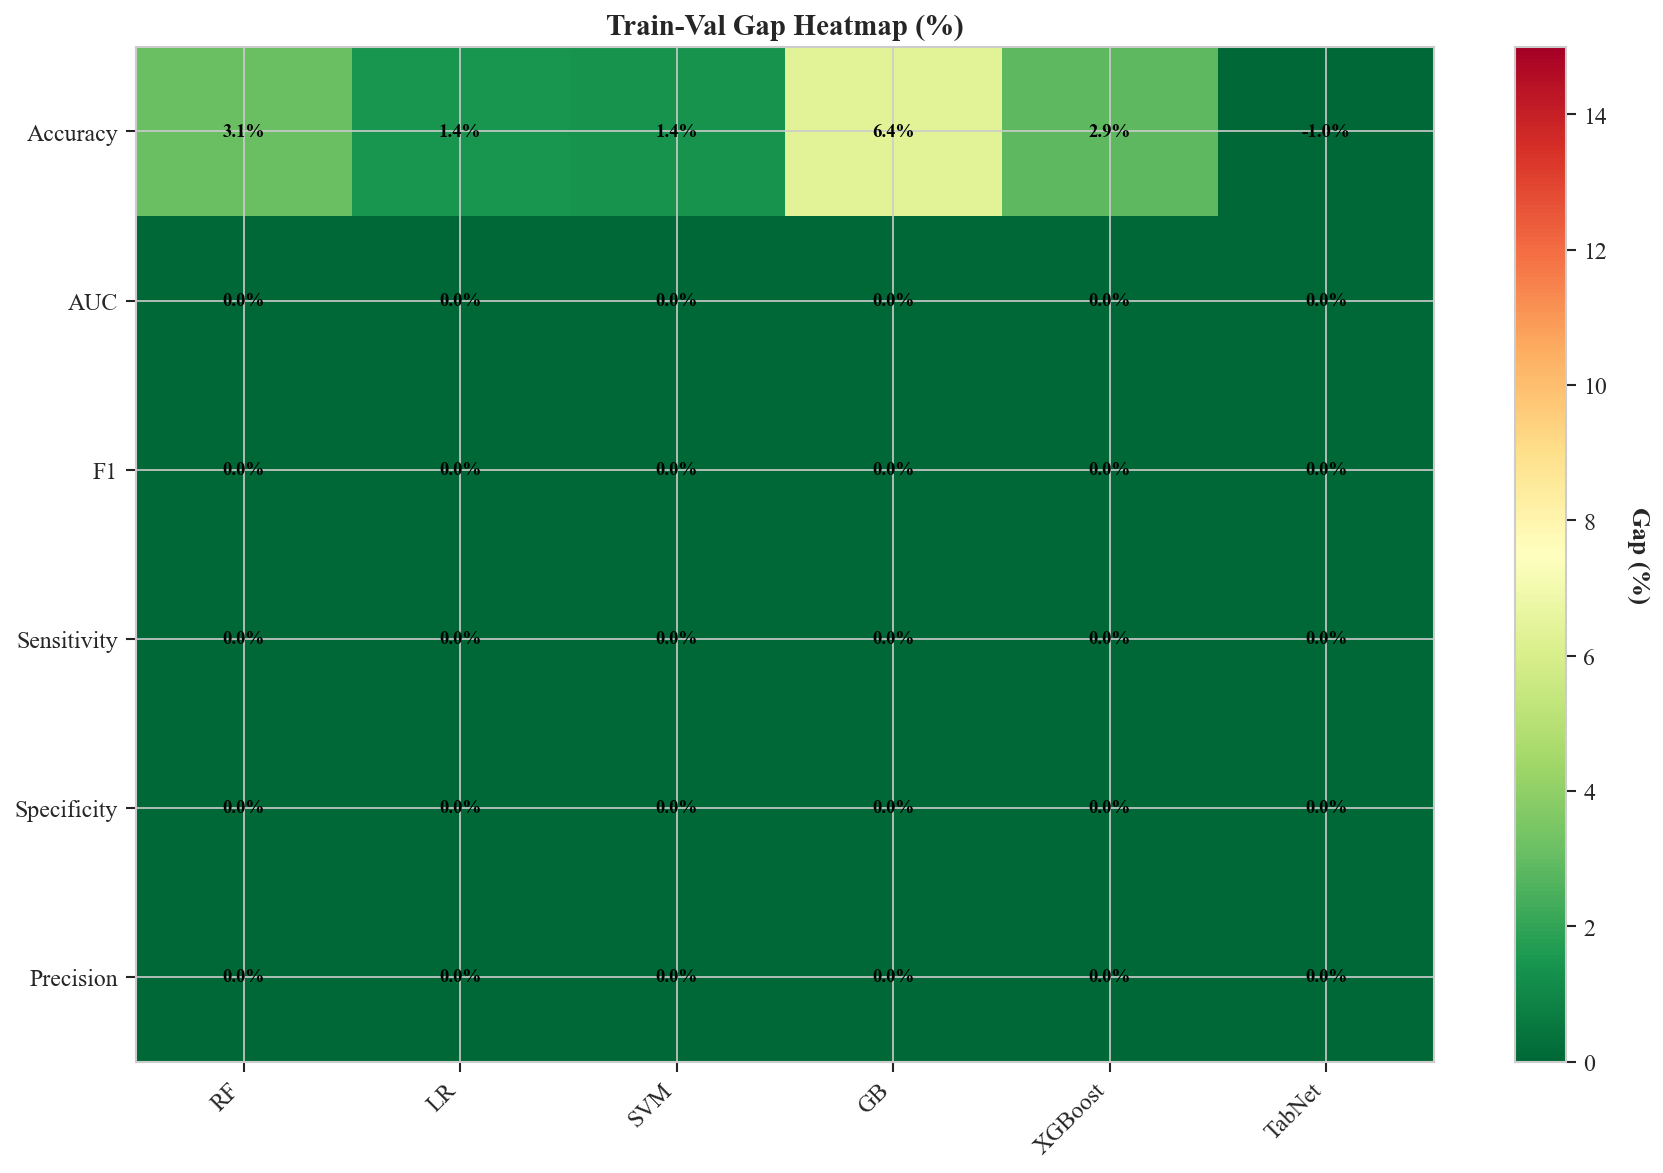


Generating gap analysis plot...
Saved: tabnet_performance_results\figure_07_gap_analysis.png


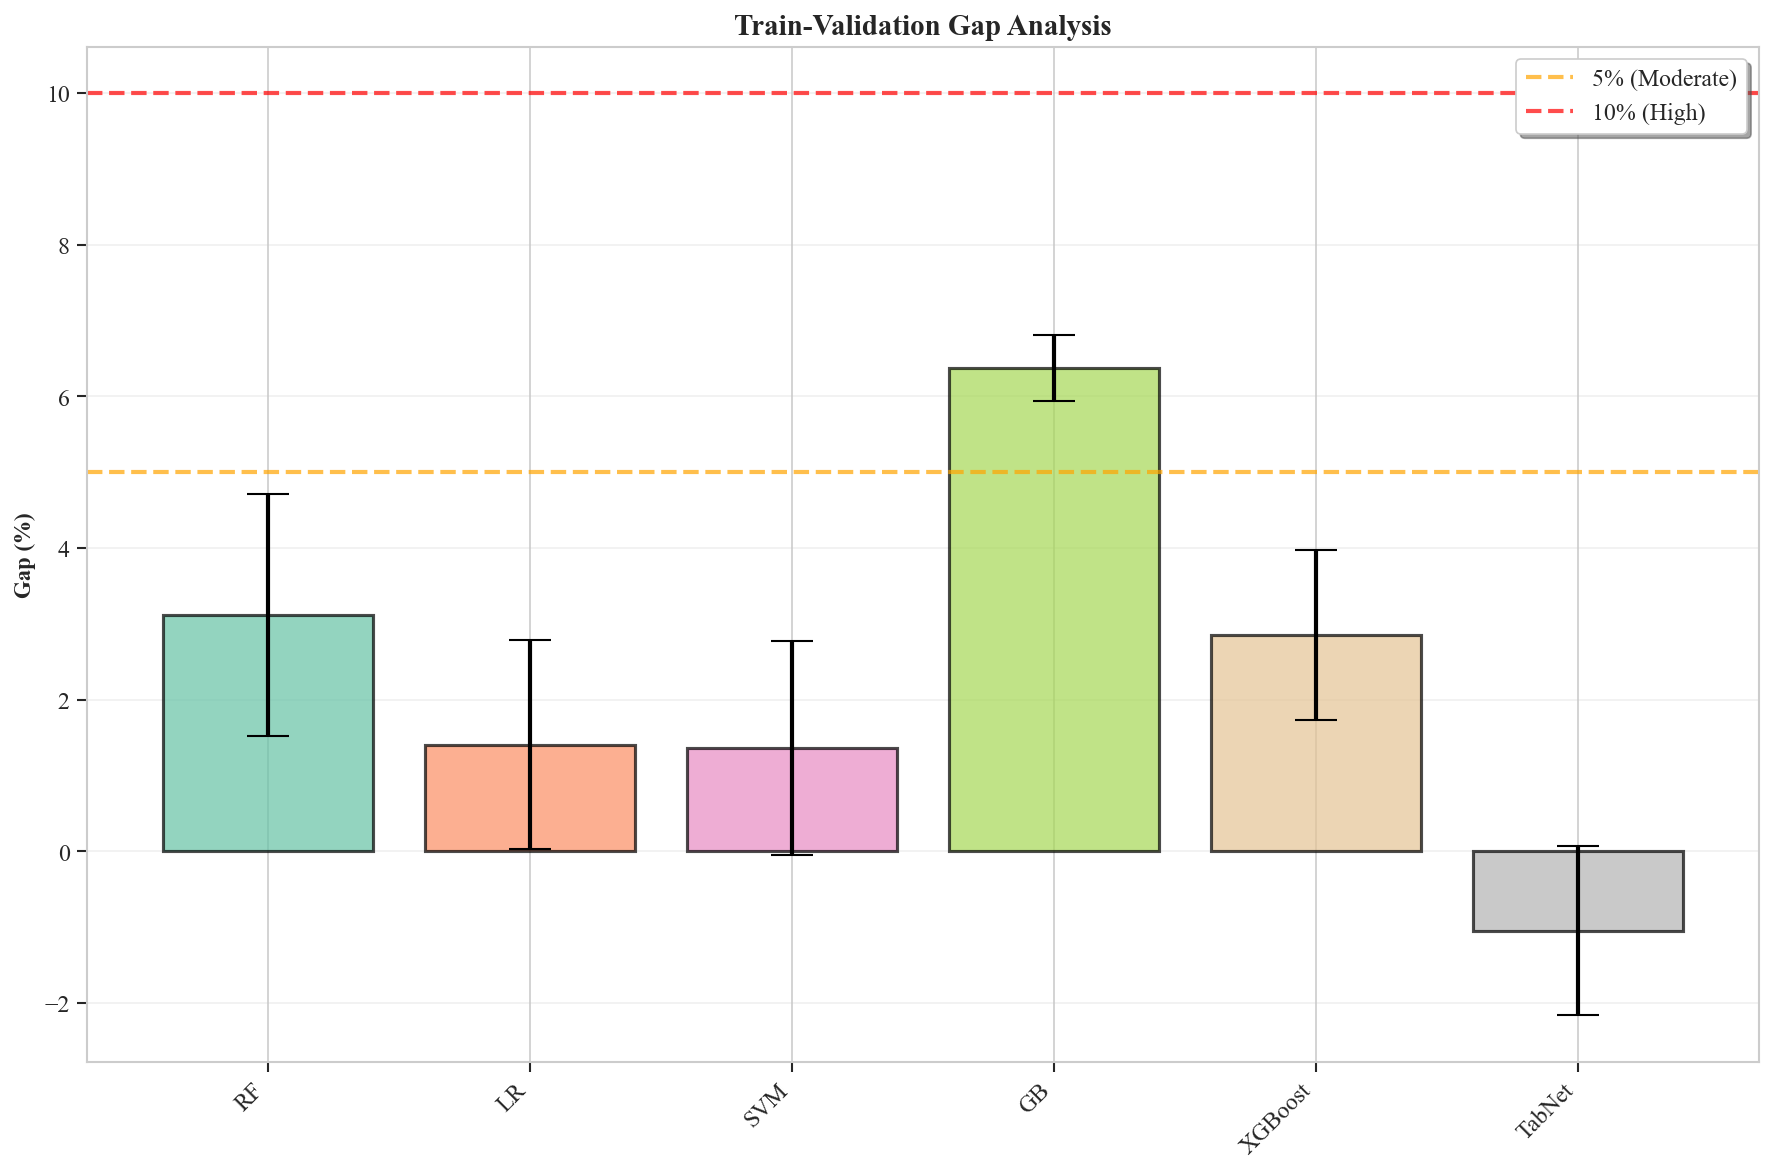


Generating stability score plot...
Saved: tabnet_performance_results\figure_08_stability_score.png


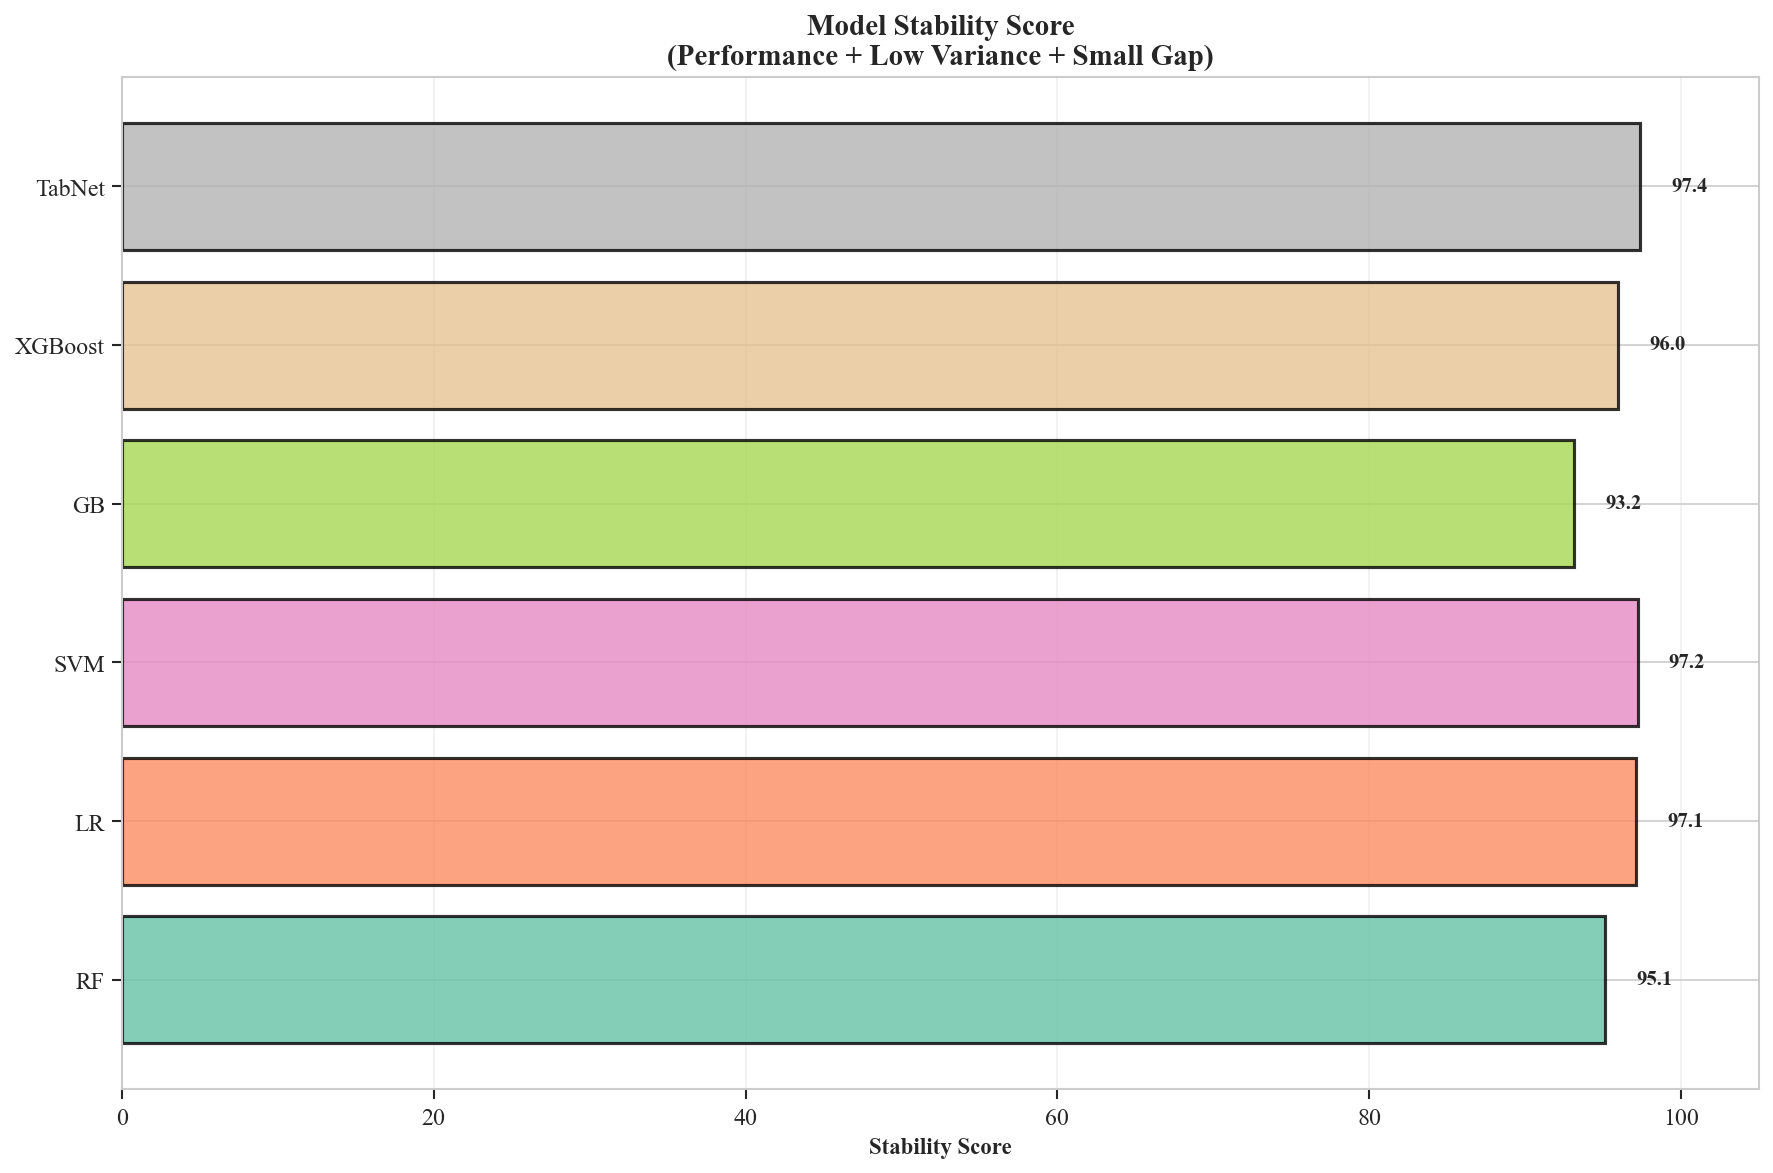


Generating summary table...
Saved: tabnet_performance_results\figure_09_summary_table.png


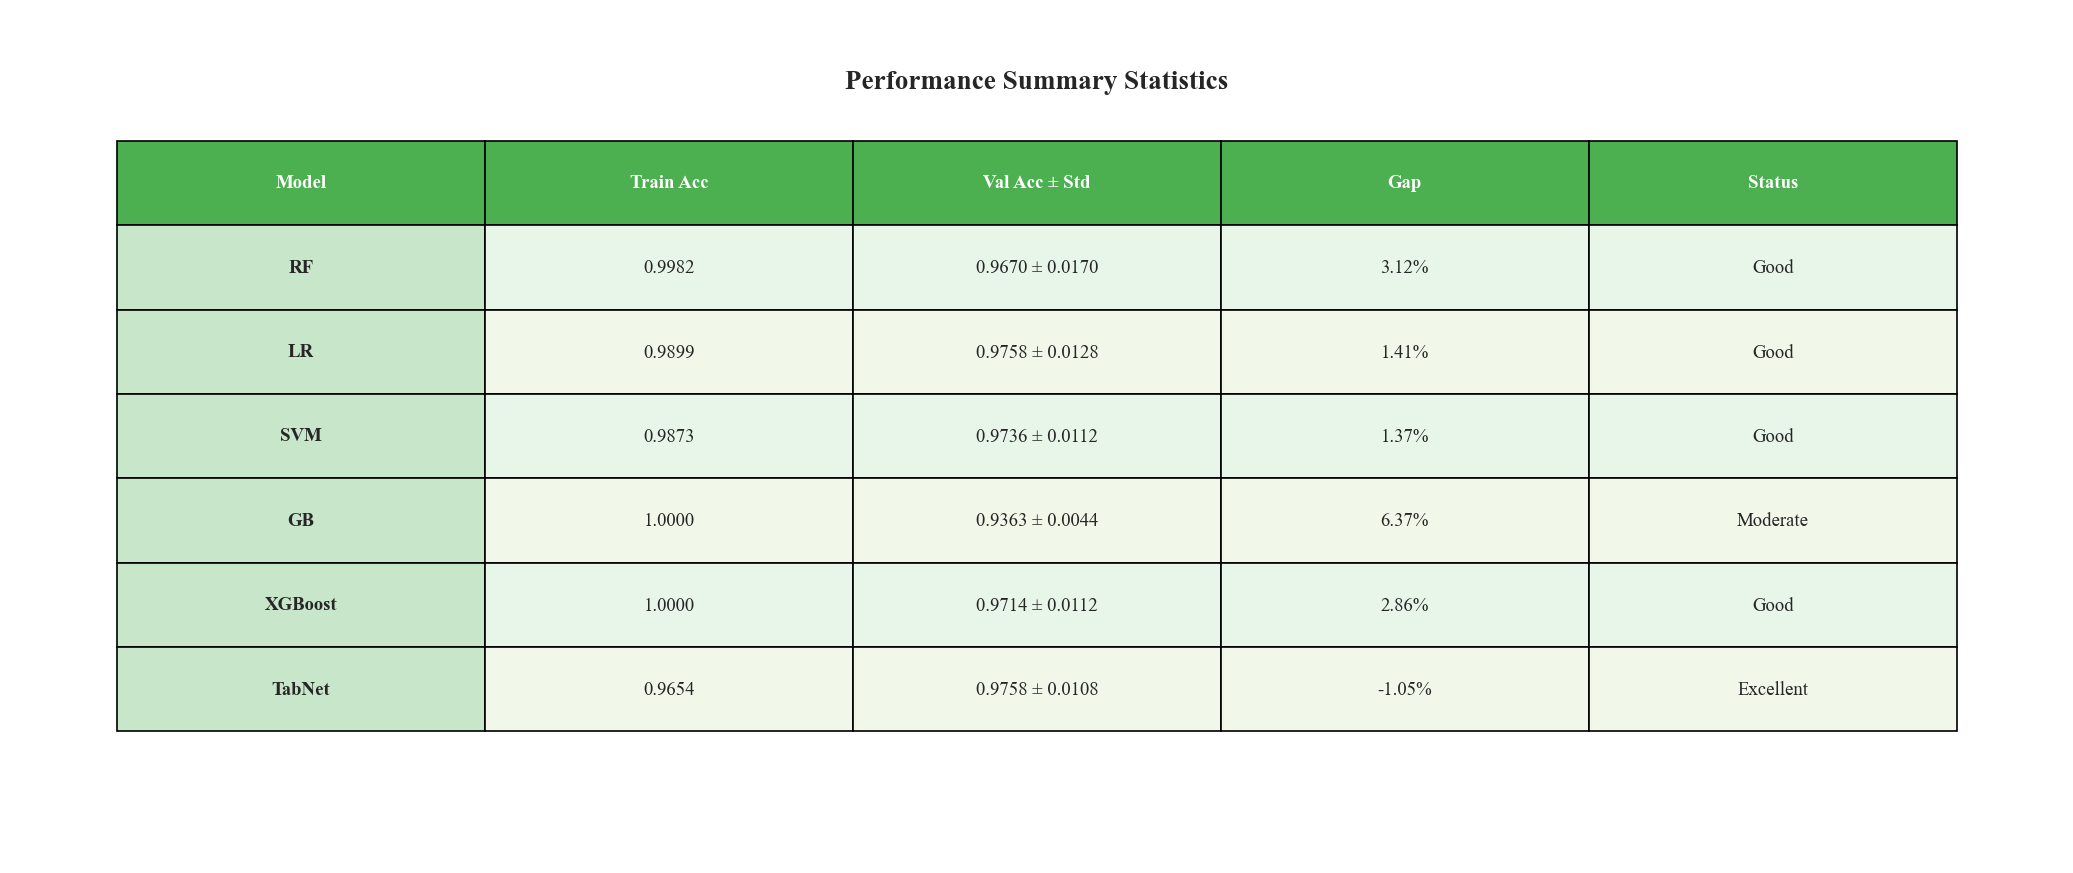


Generating feature importance plot...
Saved: tabnet_performance_results\figure_10_feature_importance.png


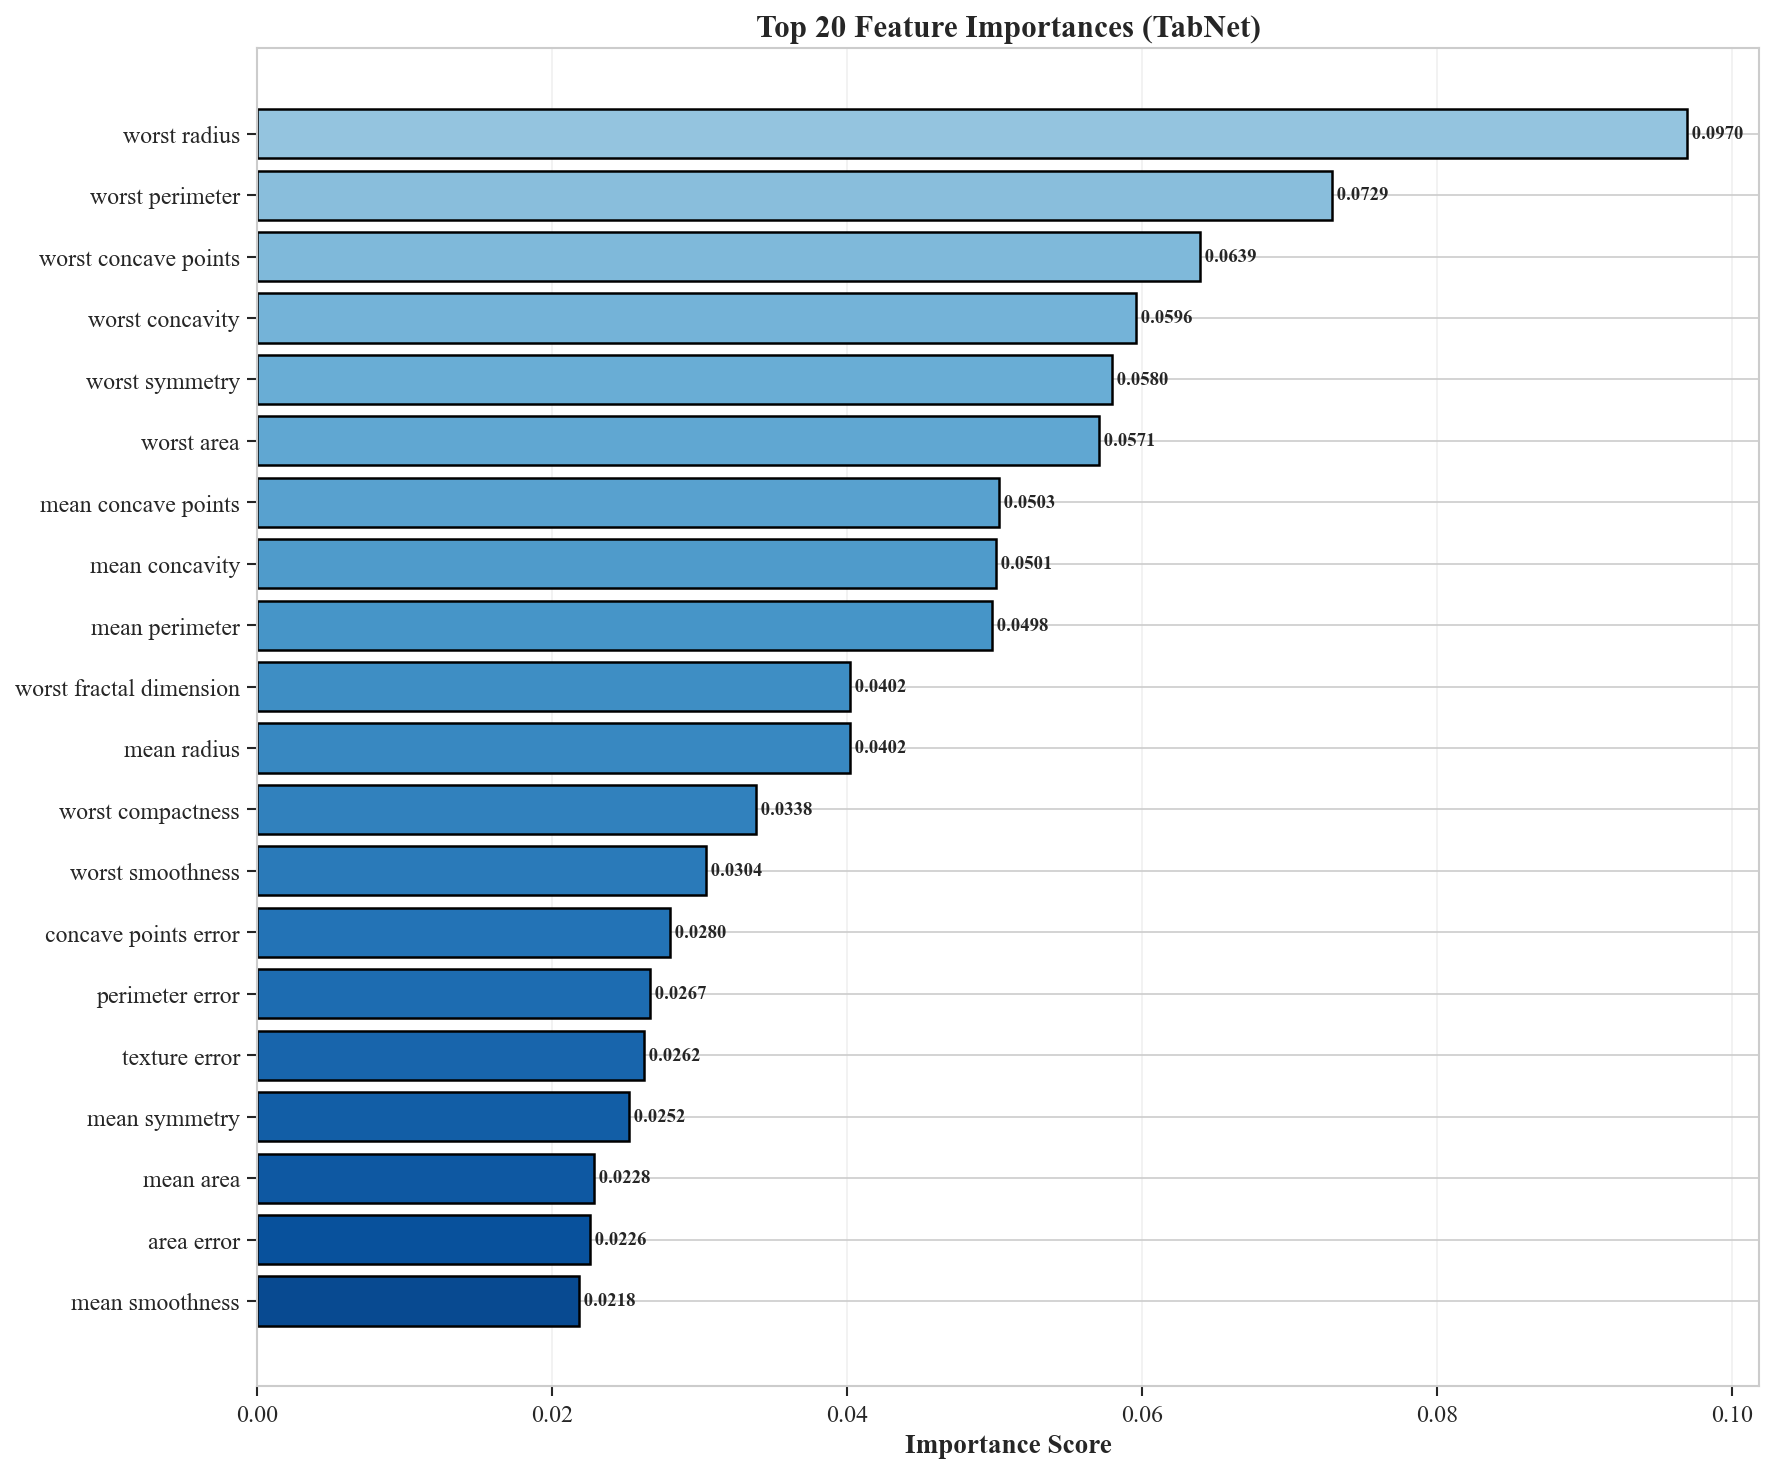


Generating confusion matrix for TabNet...
Saved: tabnet_performance_results\figure_11_confusion_matrix_tabnet.png


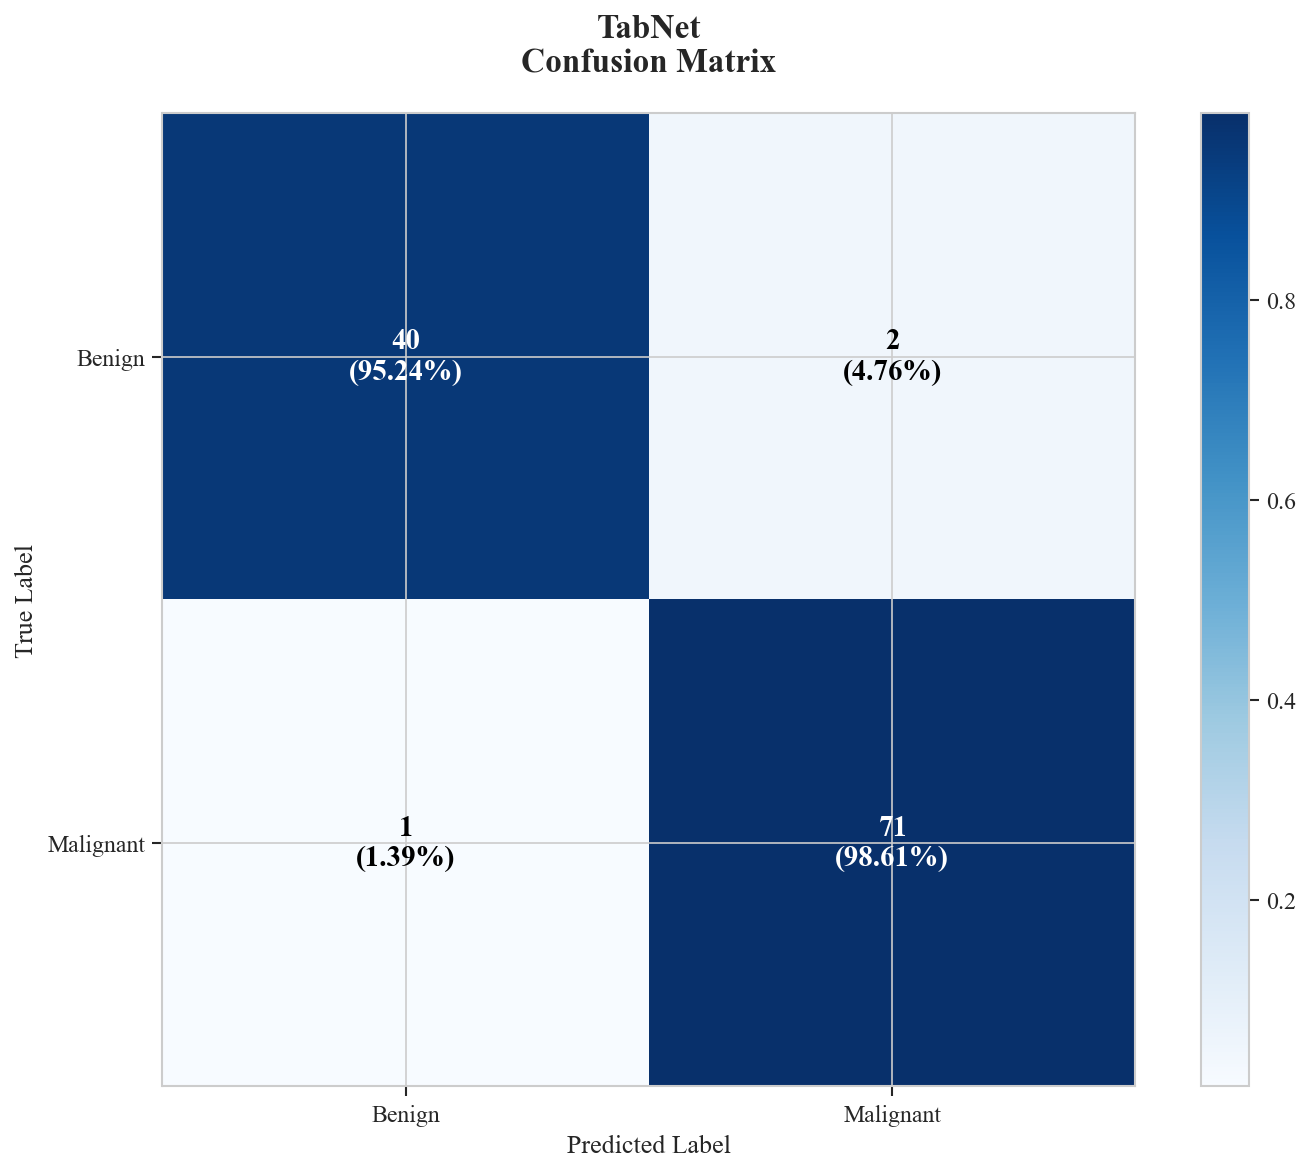


Results saved: tabnet_performance_results\performance_results.json
All visualizations saved in: tabnet_performance_results/

EXPERIMENT COMPLETED

Experiment complete with publication-quality visualizations


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
from pathlib import Path
import json
from datetime import datetime
from typing import Dict, List, Tuple, Any
import sys
import os
from collections import defaultdict

# ML imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, 
    matthews_corrcoef, cohen_kappa_score,
    roc_curve, precision_recall_curve, auc,
    average_precision_score, brier_score_loss,
    log_loss, classification_report
)
from sklearn.calibration import calibration_curve

# Statistical testing
from scipy import stats
from scipy.stats import wilcoxon, friedmanchisquare

# Baseline models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# SMOTE for imbalanced data
try:
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.combine import SMOTEENN
    _HAS_IMBLEARN = True
except ImportError:
    _HAS_IMBLEARN = False
    print("Warning: imbalanced-learn not available. Install with: pip install imbalanced-learn")

# TabNet
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    from pytorch_tabnet.augmentations import ClassificationSMOTE
    _HAS_TABNET = True
except ImportError:
    _HAS_TABNET = False
    print("Warning: TabNet not available. Install with: pip install pytorch-tabnet")

# XGBoost
try:
    from xgboost import XGBClassifier
    _HAS_XGBOOST = True
except ImportError:
    _HAS_XGBOOST = False

# Optuna for hyperparameter optimization
try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    _HAS_OPTUNA = True
except ImportError:
    _HAS_OPTUNA = False
    print("Warning: Optuna not available. Install with: pip install optuna")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Patch
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.ion()


# =============================================================================
# ENHANCED CONFIGURATION FOR TABNET PERFORMANCE
# =============================================================================

class Config:
    """Performance-optimized configuration for TabNet"""
    
    def __init__(self, dataset_path="data.csv"):
        # Data
        self.DATASET_PATH = dataset_path
        self.TARGET_COL = "diagnosis"
        self.TEST_SIZE = 0.2
        self.RANDOM_SEED = 42
        
        # Cross-validation - MODIFIED
        self.CV_FOLDS = 5  # Changed from 10
        self.CV_REPEATS = 1  # Changed from 3
        
        # TabNet-specific SMOTE strategy
        self.USE_SMOTE = True
        self.USE_TABNET_SMOTE = True
        self.SMOTE_STRATEGY = 'auto'
        
        # Hyperparameter optimization
        self.USE_OPTUNA = True
        self.OPTUNA_TRIALS = 200
        self.OPTUNA_TIMEOUT = 7200
        self.USE_PRUNING = True
        
        # TabNet hyperparameter ranges
        self.TABNET_N_D_RANGE = (32, 256)
        self.TABNET_N_A_RANGE = (32, 256)
        self.TABNET_N_STEPS_RANGE = (4, 10)
        self.TABNET_GAMMA_RANGE = (1.2, 2.0)
        self.TABNET_LAMBDA_SPARSE_RANGE = (1e-6, 1e-3)
        self.TABNET_LR_RANGE = (0.005, 0.03)
        self.TABNET_MOMENTUM_RANGE = (0.90, 0.98)
        self.TABNET_MASK_TYPE = ['sparsemax']
        
        # Training parameters
        self.TABNET_MAX_EPOCHS = 500
        self.TABNET_PATIENCE = 100
        self.TABNET_BATCH_SIZE = 1024
        self.TABNET_VIRTUAL_BATCH = 256
        self.USE_GRADIENT_CLIPPING = True
        self.GRADIENT_CLIP_VALUE = 1.0
        
        # Learning rate scheduling
        self.USE_LR_SCHEDULER = True
        self.SCHEDULER_PATIENCE = 20
        self.SCHEDULER_FACTOR = 0.5
        self.MIN_LR = 1e-5
        
        # Class imbalance handling
        self.USE_CLASS_WEIGHTS = True
        self.CLASS_WEIGHT_STRATEGY = 'balanced'
        
        # Statistical testing
        self.ALPHA = 0.05
        self.BONFERRONI_CORRECTION = True
        self.CONFIDENCE_LEVEL = 0.95
        
        # Results
        self.RESULTS_DIR = "tabnet_performance_results"
        
        # Visualization
        self.DISPLAY_PLOTS = True
        self.SAVE_PLOTS = True
        self.PLOT_FORMAT = 'png'
        self.PLOT_DPI = 300


# =============================================================================
# DATASET UTILITIES
# =============================================================================

def download_wisconsin_breast_cancer(save_path="data.csv"):
    """Download Wisconsin Breast Cancer dataset if not provided"""
    print("\nDownloading Wisconsin Breast Cancer dataset...")
    
    if os.path.sep in save_path or '/' in save_path:
        save_path = os.path.basename(save_path)
    
    if save_path.startswith('-') or save_path.startswith('--'):
        save_path = "data.csv"
    
    try:
        from sklearn.datasets import load_breast_cancer
        
        data = load_breast_cancer()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['diagnosis'] = data.target
        df['diagnosis'] = df['diagnosis'].map({1: 'M', 0: 'B'})
        
        df.to_csv(save_path, index=False)
        print(f"Downloaded and saved to: {save_path}")
        print(f"Dataset shape: {df.shape}")
        
        return save_path
        
    except Exception as e:
        print(f"Failed to download dataset: {str(e)}")
        return None


def check_dataset_exists(dataset_path):
    """Check if dataset exists, download if not"""
    if dataset_path.startswith('-') or dataset_path.startswith('--'):
        dataset_path = "data.csv"
    
    if os.path.exists(dataset_path):
        print(f"Found dataset: {dataset_path}")
        return dataset_path
    
    print(f"\nDataset not found: {dataset_path}")
    
    try:
        get_ipython()
        print("Detected notebook environment - auto-downloading dataset...")
        new_path = download_wisconsin_breast_cancer(dataset_path)
        if new_path:
            return new_path
        else:
            sys.exit(1)
    except NameError:
        print("\nOptions:")
        print("1. Download Wisconsin Breast Cancer dataset (default)")
        print("2. Specify a different path")
        print("3. Exit")
        
        choice = input("\nEnter choice (1/2/3) [default=1]: ").strip() or "1"
        
        if choice == "1":
            new_path = download_wisconsin_breast_cancer(dataset_path)
            if new_path:
                return new_path
            else:
                sys.exit(1)
        elif choice == "2":
            new_path = input("Enter dataset path: ").strip()
            if os.path.exists(new_path):
                return new_path
            else:
                print(f"Path not found: {new_path}")
                sys.exit(1)
        else:
            print("Exiting.")
            sys.exit(0)


# =============================================================================
# ENHANCED VISUALIZATION MODULE
# =============================================================================

class VisualizationSuite:
    """Comprehensive visualization suite for TabNet experiments"""
    
    def __init__(self, config: Config):
        self.config = config
        self.results_dir = Path(config.RESULTS_DIR)
        self.results_dir.mkdir(exist_ok=True, parents=True)
    
    def plot_boxplot_comparison_with_ci(self, all_results: Dict[str, List[Dict]]):
        """Create box plot comparison with 95% confidence intervals"""
        print("\nGenerating box plot comparison with 95% CI...")
        
        # Define metrics to plot
        metrics_info = [
            ('accuracy', 'Accuracy Distribution'),
            ('auc', 'AUC Distribution'),
            ('f1', 'F1 Distribution'),
            ('sensitivity', 'Sensitivity Distribution'),
            ('specificity', 'Specificity Distribution'),
            ('precision', 'Precision Distribution')
        ]
        
        # Create figure with 2 rows, 3 columns
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('Model Performance Comparison with 95% Confidence Intervals', 
                    fontsize=20, fontweight='bold', y=0.98)
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        for idx, (metric_key, metric_title) in enumerate(metrics_info):
            ax = plt.subplot(2, 3, idx + 1)
            
            # Collect data for each model
            data_list = []
            means_list = []
            ci_list = []
            
            for model_name in model_names:
                results = all_results[model_name]
                values = [r.get(metric_key, 0) for r in results if metric_key in r]
                
                if values:
                    data_list.append(values)
                    mean_val = np.mean(values)
                    means_list.append(mean_val)
                    
                    # Calculate 95% CI
                    n = len(values)
                    if n > 1:
                        std_err = stats.sem(values)
                        ci = std_err * stats.t.ppf(0.975, n - 1)
                        ci_list.append((mean_val - ci, mean_val + ci))
                    else:
                        ci_list.append((mean_val, mean_val))
                else:
                    data_list.append([])
                    means_list.append(0)
                    ci_list.append((0, 0))
            
            # Create box plots
            positions = np.arange(len(model_names))
            bp = ax.boxplot(data_list, positions=positions, widths=0.6,
                           patch_artist=True, showfliers=True,
                           boxprops=dict(linewidth=1.5),
                           whiskerprops=dict(linewidth=1.5),
                           capprops=dict(linewidth=1.5),
                           medianprops=dict(linewidth=2, color='black'),
                           flierprops=dict(marker='o', markerfacecolor='black', 
                                          markersize=5, alpha=0.6))
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add mean with CI as diamond markers with error bars
            for i, (mean_val, (ci_lower, ci_upper)) in enumerate(zip(means_list, ci_list)):
                ax.plot(i, mean_val, marker='D', markersize=10, 
                       color='darkred', markeredgecolor='white', 
                       markeredgewidth=2, zorder=5)
                ax.errorbar(i, mean_val, yerr=[[mean_val - ci_lower], [ci_upper - mean_val]],
                           fmt='none', ecolor='darkred', elinewidth=2, 
                           capsize=5, capthick=2, zorder=4)
            
            # Formatting
            ax.set_ylabel(metric_title.split()[0], fontsize=12, fontweight='bold')
            ax.set_title(metric_title, fontsize=13, fontweight='bold', pad=10)
            ax.set_xticks(positions)
            ax.set_xticklabels(model_names, rotation=45, ha='right')
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add sample size annotation
            n_samples = len(data_list[0]) if data_list[0] else 0
            ax.text(0.5, -0.25, f'n={n_samples}', 
                   transform=ax.transAxes, ha='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Add legend in first subplot
            if idx == 0:
                legend_elements = [
                    mpatches.Patch(facecolor='gray', alpha=0.7, label='Box: IQR'),
                    plt.Line2D([0], [0], color='black', linewidth=2, label='Median'),
                    plt.Line2D([0], [0], marker='D', color='w', 
                              markerfacecolor='darkred', markersize=10, 
                              markeredgecolor='white', markeredgewidth=2,
                              label='Mean ± 95% CI')
                ]
                ax.legend(handles=legend_elements, loc='lower left', 
                         frameon=True, shadow=True, fontsize=9)
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_01_boxplot_comparison_ci.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_optuna_results(self, study):
        """Plot hyperparameter optimization history and importance"""
        print("\nGenerating Optuna optimization plots...")
        
        fig = plt.figure(figsize=(16, 6))
        gs = GridSpec(1, 2, figure=fig, wspace=0.3)
        
        # Left: Optimization History
        ax1 = fig.add_subplot(gs[0, 0])
        trials = study.trials
        trial_numbers = [t.number for t in trials if t.state == optuna.trial.TrialState.COMPLETE]
        scores = [t.value for t in trials if t.state == optuna.trial.TrialState.COMPLETE]
        
        # Running best
        running_best = []
        best_so_far = -np.inf
        for score in scores:
            best_so_far = max(best_so_far, score)
            running_best.append(best_so_far)
        
        ax1.plot(trial_numbers, scores, 'o-', alpha=0.6, linewidth=1, markersize=4, label='Trial Score')
        ax1.plot(trial_numbers, running_best, 'r--', linewidth=2, label=f'Best: {max(scores):.4f}')
        ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.3)
        
        ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
        ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
        ax1.set_title('Hyperparameter Optimization History', fontsize=14, fontweight='bold')
        ax1.legend(loc='lower right', frameon=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([min(scores) - 0.02, 1.01])
        
        # Right: Hyperparameter Importance
        ax2 = fig.add_subplot(gs[0, 1])
        
        try:
            importance = optuna.importance.get_param_importances(study)
            params = list(importance.keys())
            values = list(importance.values())
            
            colors = plt.cm.Oranges(np.linspace(0.4, 0.8, len(params)))
            bars = ax2.barh(params, values, color=colors, edgecolor='black', linewidth=1.2)
            
            ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
            ax2.set_title('Hyperparameter Importance', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax2.text(width, bar.get_y() + bar.get_height()/2, 
                        f'{width:.2f}', ha='left', va='center', fontsize=9)
        except Exception as e:
            ax2.text(0.5, 0.5, 'Importance calculation unavailable',
                    ha='center', va='center', transform=ax2.transAxes)
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_02_optuna_optimization.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_train_val_performance(self, all_results: Dict[str, List[Dict]]):
        """Plot training vs validation performance"""
        print("\nGenerating training vs validation performance plot...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        x = np.arange(len(model_names))
        width = 0.35
        
        train_acc = []
        val_acc = []
        gaps = []
        
        for name in model_names:
            results = all_results[name]
            train_acc.append(np.mean([r.get('train_accuracy', r.get('accuracy', 0)) for r in results]))
            val_acc.append(np.mean([r.get('accuracy', 0) for r in results]))
            gaps.append(train_acc[-1] - val_acc[-1])
        
        bars1 = ax.bar(x - width/2, train_acc, width, label='Training', 
                      color=[c for c in colors], edgecolor='black', linewidth=1.2)
        bars2 = ax.bar(x + width/2, val_acc, width, label='Validation',
                      color=[c for c in colors], alpha=0.6, edgecolor='black', 
                      linewidth=1.2, hatch='///')
        
        # Add percentage labels on bars
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            gap = (height1 - height2) * 100
            
            ax.text(bar1.get_x() + bar1.get_width()/2, height1 + 0.005,
                   f'{gap:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title('Training vs Validation Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend(loc='lower right', frameon=True, shadow=True)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0.85, 1.02])
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_03_train_val_performance.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_metric_variance(self, all_results: Dict[str, List[Dict]]):
        """Plot coefficient of variation for different metrics"""
        print("\nGenerating metric variance plot...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        metrics = ['Accuracy', 'AUC', 'F1', 'Precision', 'Sensitivity', 'Specificity']
        metric_keys = ['accuracy', 'auc', 'f1', 'precision', 'sensitivity', 'specificity']
        
        cv_data = {metric: [] for metric in metrics}
        
        for name in model_names:
            results = all_results[name]
            for metric, key in zip(metrics, metric_keys):
                values = [r.get(key, 0) for r in results if key in r]
                if values:
                    cv = (np.std(values) / np.mean(values)) * 100 if np.mean(values) > 0 else 0
                    cv_data[metric].append(cv)
                else:
                    cv_data[metric].append(0)
        
        x = np.arange(len(metrics))
        width = 0.8 / len(model_names)
        
        for i, (name, color) in enumerate(zip(model_names, colors)):
            values = [cv_data[metric][i] for metric in metrics]
            ax.barh(x + i * width, values, width, label=name, color=color,
                   edgecolor='black', linewidth=0.8)
        
        ax.axvline(x=5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='5% threshold')
        ax.axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='10% threshold')
        
        ax.set_xlabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
        ax.set_title('Metric Variance Across CV Folds', fontsize=14, fontweight='bold')
        ax.set_yticks(x + width * (len(model_names) - 1) / 2)
        ax.set_yticklabels(metrics)
        ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=8)
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_04_metric_variance.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_accuracy_distribution(self, all_results: Dict[str, List[Dict]]):
        """Plot accuracy distribution as violin plot"""
        print("\nGenerating accuracy distribution plot...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        data_list = []
        labels = []
        
        for name in model_names:
            results = all_results[name]
            accuracies = [r.get('accuracy', 0) for r in results]
            data_list.append(accuracies)
            labels.append(name)
        
        parts = ax.violinplot(data_list, positions=range(len(labels)), 
                             widths=0.7, showmeans=True, showextrema=True)
        
        for i, (pc, color) in enumerate(zip(parts['bodies'], colors)):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.5)
        
        parts['cmeans'].set_color('black')
        parts['cmeans'].set_linewidth(2)
        
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title('Accuracy Distribution (Violin Plot)', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0.8, 1.0])
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_05_accuracy_distribution.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_gap_heatmap(self, all_results: Dict[str, List[Dict]]):
        """Plot train-validation gap as heatmap"""
        print("\nGenerating gap heatmap...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        metrics = ['Accuracy', 'AUC', 'F1', 'Sensitivity', 'Specificity', 'Precision']
        metric_keys = ['accuracy', 'auc', 'f1', 'sensitivity', 'specificity', 'precision']
        
        gap_matrix = []
        
        for name in model_names:
            results = all_results[name]
            gaps = []
            for key in metric_keys:
                train_val = np.mean([r.get(f'train_{key}', r.get(key, 0)) for r in results])
                val_val = np.mean([r.get(key, 0) for r in results])
                gap = (train_val - val_val) * 100
                gaps.append(gap)
            gap_matrix.append(gaps)
        
        gap_matrix = np.array(gap_matrix)
        
        im = ax.imshow(gap_matrix.T, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=15)
        
        ax.set_xticks(np.arange(len(model_names)))
        ax.set_yticks(np.arange(len(metrics)))
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_yticklabels(metrics)
        
        # Add text annotations
        for i in range(len(model_names)):
            for j in range(len(metrics)):
                text = ax.text(i, j, f'{gap_matrix[i, j]:.1f}%',
                             ha="center", va="center", color="black", fontsize=9, fontweight='bold')
        
        ax.set_title('Train-Val Gap Heatmap (%)', fontsize=14, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Gap (%)', rotation=270, labelpad=20, fontweight='bold')
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_06_gap_heatmap.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_gap_analysis(self, all_results: Dict[str, List[Dict]]):
        """Plot train-validation gap analysis with error bars"""
        print("\nGenerating gap analysis plot...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        gaps_data = []
        
        for name in model_names:
            results = all_results[name]
            gaps = []
            for r in results:
                train_acc = r.get('train_accuracy', r.get('accuracy', 0))
                val_acc = r.get('accuracy', 0)
                gap = (train_acc - val_acc) * 100
                gaps.append(gap)
            gaps_data.append(gaps)
        
        positions = range(len(model_names))
        means = [np.mean(gaps) for gaps in gaps_data]
        stds = [np.std(gaps) for gaps in gaps_data]
        
        ax.bar(positions, means, yerr=stds, capsize=10, color=colors,
              edgecolor='black', linewidth=1.5, alpha=0.7, error_kw={'linewidth': 2})
        
        ax.axhline(y=5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='5% (Moderate)')
        ax.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='10% (High)')
        
        ax.set_ylabel('Gap (%)', fontsize=11, fontweight='bold')
        ax.set_title('Train-Validation Gap Analysis', fontsize=14, fontweight='bold')
        ax.set_xticks(positions)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend(loc='upper right', frameon=True, shadow=True)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_07_gap_analysis.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_stability_score(self, all_results: Dict[str, List[Dict]]):
        """Plot model stability score"""
        print("\nGenerating stability score plot...")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        model_names = list(all_results.keys())
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
        
        stability_scores = []
        
        for name in model_names:
            results = all_results[name]
            
            # Calculate stability components
            acc_values = [r.get('accuracy', 0) for r in results]
            acc_cv = (np.std(acc_values) / np.mean(acc_values)) * 100 if np.mean(acc_values) > 0 else 0
            
            # Gap component
            gaps = []
            for r in results:
                train_acc = r.get('train_accuracy', r.get('accuracy', 0))
                val_acc = r.get('accuracy', 0)
                gap = abs(train_acc - val_acc) * 100
                gaps.append(gap)
            avg_gap = np.mean(gaps)
            
            # Stability score: 100 - (CV + Gap)
            stability = max(0, 100 - acc_cv - avg_gap)
            stability_scores.append(stability)
        
        bars = ax.barh(model_names, stability_scores, color=colors,
                      edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add score labels
        for bar, score in zip(bars, stability_scores):
            width = bar.get_width()
            ax.text(width + 2, bar.get_y() + bar.get_height()/2,
                   f'{score:.1f}', ha='left', va='center', 
                   fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Stability Score', fontsize=11, fontweight='bold')
        ax.set_title('Model Stability Score\n(Performance + Low Variance + Small Gap)',
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_xlim([0, 105])
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_08_stability_score.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_summary_table(self, all_results: Dict[str, List[Dict]]):
        """Plot performance summary table"""
        print("\nGenerating summary table...")
        
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.axis('off')
        
        model_names = list(all_results.keys())
        table_data = []
        headers = ['Model', 'Train Acc', 'Val Acc ± Std', 'Gap', 'Status']
        
        for name in model_names:
            results = all_results[name]
            
            # Compute metrics
            train_accs = [r.get('train_accuracy', r.get('accuracy', 0)) for r in results]
            val_accs = [r.get('accuracy', 0) for r in results]
            
            train_mean = np.mean(train_accs)
            val_mean = np.mean(val_accs)
            val_std = np.std(val_accs)
            gap = (train_mean - val_mean) * 100
            
            # Status indicator
            if gap < 1:
                status = 'Excellent'
            elif gap < 5:
                status = 'Good'
            else:
                status = 'Moderate'
            
            table_data.append([
                name,
                f"{train_mean:.4f}",
                f"{val_mean:.4f} ± {val_std:.4f}",
                f"{gap:.2f}%",
                status
            ])
        
        # Create table
        table = ax.table(cellText=table_data, colLabels=headers,
                        cellLoc='center', loc='center',
                        bbox=[0.05, 0.15, 0.9, 0.7])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        
        # Style header
        for i in range(len(headers)):
            cell = table[(0, i)]
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        
        # Style data rows
        for i in range(len(table_data)):
            row_color = '#E8F5E9' if i % 2 == 0 else '#F1F8E9'
            for j in range(len(headers)):
                cell = table[(i+1, j)]
                if j == 0:
                    cell.set_facecolor('#C8E6C9')
                    cell.set_text_props(weight='bold')
                else:
                    cell.set_facecolor(row_color)
        
        ax.text(0.5, 0.92, 'Performance Summary Statistics', 
               ha='center', va='center', fontsize=13, fontweight='bold',
               transform=ax.transAxes)
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_09_summary_table.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()
    
    def plot_feature_importance(self, model, feature_names, top_n=20):
        """Plot TabNet feature importances"""
        print("\nGenerating feature importance plot...")
        
        try:
            # Get feature importances
            importances = model.feature_importances_
            
            # Sort and get top N
            indices = np.argsort(importances)[::-1][:top_n]
            top_features = [feature_names[i] for i in indices]
            top_importances = importances[indices]
            
            # Create plot
            fig, ax = plt.subplots(figsize=(12, 10))
            
            colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features)))
            bars = ax.barh(range(len(top_features)), top_importances, 
                          color=colors, edgecolor='black', linewidth=1.2)
            
            ax.set_yticks(range(len(top_features)))
            ax.set_yticklabels(top_features)
            ax.invert_yaxis()
            ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
            ax.set_title(f'Top {top_n} Feature Importances (TabNet)', 
                        fontsize=15, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (bar, val) in enumerate(zip(bars, top_importances)):
                ax.text(val, i, f' {val:.4f}', va='center', fontsize=9, fontweight='bold')
            
            plt.tight_layout()
            
            if self.config.SAVE_PLOTS:
                output_path = self.results_dir / f"figure_10_feature_importance.{self.config.PLOT_FORMAT}"
                plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
                print(f"Saved: {output_path}")
            
            if self.config.DISPLAY_PLOTS:
                plt.show()
            else:
                plt.close()
                
        except Exception as e:
            print(f"Could not plot feature importance: {e}")
    
    def plot_confusion_matrix(self, y_true, y_pred, model_name="TabNet"):
        """Plot confusion matrix"""
        print(f"\nGenerating confusion matrix for {model_name}...")
        
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot heatmap
        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
        ax.figure.colorbar(im, ax=ax)
        
        # Labels
        classes = ['Benign', 'Malignant']
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes,
               yticklabels=classes,
               ylabel='True Label',
               xlabel='Predicted Label')
        
        ax.set_title(f'{model_name}\nConfusion Matrix', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Rotate x labels
        plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
        
        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                count = cm[i, j]
                percentage = cm_normalized[i, j] * 100
                
                ax.text(j, i, f'{count}\n({percentage:.2f}%)',
                       ha="center", va="center",
                       color="white" if cm_normalized[i, j] > thresh else "black",
                       fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        
        if self.config.SAVE_PLOTS:
            output_path = self.results_dir / f"figure_11_confusion_matrix_{model_name.lower()}.{self.config.PLOT_FORMAT}"
            plt.savefig(output_path, dpi=self.config.PLOT_DPI, bbox_inches='tight')
            print(f"Saved: {output_path}")
        
        if self.config.DISPLAY_PLOTS:
            plt.show()
        else:
            plt.close()


# =============================================================================
# PERFORMANCE-OPTIMIZED TABNET OPTIMIZER
# =============================================================================

class TabNetOptimizer:
    """Enhanced hyperparameter optimization focused on performance"""
    
    def __init__(self, config: Config):
        self.config = config
        self.best_params = None
        self.study = None
    
    def objective(self, trial, X_train, y_train, X_val, y_val):
        """Optimized objective function with better hyperparameter ranges"""
        
        n_d = trial.suggest_categorical('n_d', [32, 64, 96, 128, 192, 256])
        n_a = trial.suggest_categorical('n_a', [32, 64, 96, 128, 192, 256])
        n_steps = trial.suggest_int('n_steps', 4, 10)
        gamma = trial.suggest_float('gamma', 1.2, 2.0)
        lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True)
        lr = trial.suggest_float('lr', 0.005, 0.03, log=True)
        momentum = trial.suggest_float('momentum', 0.90, 0.98)
        
        n_train = X_train.shape[0]
        batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048])
        batch_size = min(batch_size, n_train // 2)
        batch_size = max(64, batch_size)
        
        virtual_batch_size = batch_size // 4
        virtual_batch_size = max(32, min(virtual_batch_size, 256))
        
        try:
            model = TabNetClassifier(
                n_d=n_d,
                n_a=n_a,
                n_steps=n_steps,
                gamma=gamma,
                lambda_sparse=lambda_sparse,
                momentum=momentum,
                mask_type='sparsemax',
                optimizer_fn=torch.optim.Adam,
                optimizer_params={"lr": lr, "weight_decay": 1e-5},
                scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                scheduler_params={
                    "mode": "max",
                    "factor": 0.5,
                    "patience": 15,
                    "min_lr": 1e-5
                },
                seed=self.config.RANDOM_SEED,
                verbose=0,
                clip_value=1.0,
            )
            
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_name=["val"],
                eval_metric=["auc", "accuracy"],
                max_epochs=150,
                patience=30,
                batch_size=batch_size,
                virtual_batch_size=virtual_batch_size,
            )
            
            y_proba = model.predict_proba(X_val)[:, 1]
            y_pred = model.predict(X_val)
            
            auc = roc_auc_score(y_val, y_proba)
            acc = accuracy_score(y_val, y_pred)
            
            combined_score = 0.7 * auc + 0.3 * acc
            
            trial.report(combined_score, step=1)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
            
            return combined_score
            
        except Exception as e:
            if isinstance(e, optuna.TrialPruned):
                raise
            print(f"Trial failed: {str(e)}")
            return 0.0
    
    def optimize(self, X_train, y_train, X_val, y_val) -> Dict:
        """Run enhanced hyperparameter optimization"""
        print(f"\n{'='*80}")
        print("PERFORMANCE-OPTIMIZED HYPERPARAMETER SEARCH")
        print(f"{'='*80}")
        print(f"Running {self.config.OPTUNA_TRIALS} trials...")
        print(f"Search space: n_d/n_a=[32-256], n_steps=[4-10], lr=[0.005-0.03]")
        
        pruner = MedianPruner(
            n_startup_trials=15,
            n_warmup_steps=10,
            interval_steps=1
        ) if self.config.USE_PRUNING else optuna.pruners.NopPruner()
        
        self.study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=self.config.RANDOM_SEED, multivariate=True, n_startup_trials=20),
            pruner=pruner
        )
        
        objective_with_data = lambda trial: self.objective(trial, X_train, y_train, X_val, y_val)
        
        self.study.optimize(
            objective_with_data,
            n_trials=self.config.OPTUNA_TRIALS,
            timeout=self.config.OPTUNA_TIMEOUT,
            show_progress_bar=True
        )
        
        self.best_params = self.study.best_params
        
        print(f"\nBest Score: {self.study.best_value:.6f}")
        print(f"\nOptimal Parameters:")
        for key, value in self.best_params.items():
            print(f"   {key:20s}: {value}")
        
        print(f"\nOptimization Statistics:")
        print(f"   Completed trials: {len([t for t in self.study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
        print(f"   Pruned trials:    {len([t for t in self.study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
        
        return self.best_params


# =============================================================================
# STATISTICAL ANALYSIS
# =============================================================================

class StatisticalAnalyzer:
    """Enhanced statistical analysis with confidence intervals"""
    
    def __init__(self, config: Config):
        self.config = config
        self.results = defaultdict(list)
    
    def add_results(self, model_name: str, metrics: Dict[str, float]):
        """Add results from one fold/repeat"""
        for metric, value in metrics.items():
            if metric != 'confusion_matrix':
                self.results[model_name].append(metrics)
    
    def compute_confidence_interval(self, data, confidence=0.95):
        """Compute confidence interval using t-distribution"""
        n = len(data)
        if n < 2:
            return 0, 0
        
        mean = np.mean(data)
        std_err = stats.sem(data)
        ci = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
        return mean - ci, mean + ci
    
    def compute_summary_statistics(self) -> pd.DataFrame:
        """Compute comprehensive statistics with confidence intervals"""
        summary = []
        
        for model_name, fold_results in self.results.items():
            df = pd.DataFrame(fold_results)
            
            stats_dict = {
                'Model': model_name,
                'N_Folds': len(fold_results)
            }
            
            for metric in ['accuracy', 'auc', 'sensitivity', 'specificity', 'f1', 'precision']:
                if metric in df.columns:
                    values = df[metric].values
                    mean_val = np.mean(values)
                    std_val = np.std(values)
                    ci_lower, ci_upper = self.compute_confidence_interval(
                        values, self.config.CONFIDENCE_LEVEL
                    )
                    
                    stats_dict.update({
                        f'{metric}_mean': mean_val,
                        f'{metric}_std': std_val,
                        f'{metric}_ci_lower': ci_lower,
                        f'{metric}_ci_upper': ci_upper
                    })
            
            summary.append(stats_dict)
        
        return pd.DataFrame(summary)
    
    def perform_statistical_tests(self, metric='accuracy') -> Dict:
        """Perform comprehensive statistical hypothesis testing"""
        print(f"\n{'='*80}")
        print(f"STATISTICAL SIGNIFICANCE TESTING ({metric.upper()})")
        print(f"{'='*80}")
        
        model_scores = {}
        for model_name, fold_results in self.results.items():
            scores = [r[metric] for r in fold_results if metric in r]
            if scores:
                model_scores[model_name] = np.array(scores)
        
        if len(model_scores) < 2:
            print("Need at least 2 models for statistical testing")
            return {}
        
        results = {}
        
        print("\nPairwise Wilcoxon Signed-Rank Tests")
        print("   " + "-" * 70)
        
        model_names = list(model_scores.keys())
        n_comparisons = len(model_names) * (len(model_names) - 1) // 2
        
        alpha_corrected = self.config.ALPHA / n_comparisons if self.config.BONFERRONI_CORRECTION else self.config.ALPHA
        
        if self.config.BONFERRONI_CORRECTION:
            print(f"   Bonferroni correction: alpha = {self.config.ALPHA}/{n_comparisons} = {alpha_corrected:.6f}")
        
        pairwise_results = []
        
        for i in range(len(model_names)):
            for j in range(i + 1, len(model_names)):
                model_a = model_names[i]
                model_b = model_names[j]
                
                scores_a = model_scores[model_a]
                scores_b = model_scores[model_b]
                
                min_len = min(len(scores_a), len(scores_b))
                scores_a = scores_a[:min_len]
                scores_b = scores_b[:min_len]
                
                stat, p_value = wilcoxon(scores_a, scores_b, alternative='two-sided')
                
                mean_diff = np.mean(scores_a) - np.mean(scores_b)
                significant = p_value < alpha_corrected
                
                pairwise_results.append({
                    'Model A': model_a,
                    'Model B': model_b,
                    'Mean Diff': mean_diff,
                    'P-value': p_value,
                    'Significant': significant
                })
                
                sig_marker = "***" if significant else ""
                winner = model_a if mean_diff > 0 else model_b
                print(f"   {model_a} vs {model_b}:")
                print(f"      Mean difference: {mean_diff:+.4f} {sig_marker}")
                print(f"      P-value: {p_value:.6f} {'(SIGNIFICANT)' if significant else ''}")
                if significant:
                    print(f"      {winner} performs significantly better")
        
        results['pairwise'] = pairwise_results
        
        return results


# =============================================================================
# MAIN EXPERIMENT CLASS
# =============================================================================

class TabNetExperiment:
    """Performance-optimized TabNet experiment with comprehensive visualization"""
    
    def __init__(self, config: Config):
        self.config = config
        self.results = {}
        self.statistical_analyzer = StatisticalAnalyzer(config)
        self.visualizer = VisualizationSuite(config)
        self.all_fold_results = defaultdict(list)
        
        self._set_seeds()
        Path(config.RESULTS_DIR).mkdir(exist_ok=True, parents=True)
    
    def _set_seeds(self):
        """Set random seeds for reproducibility"""
        np.random.seed(self.config.RANDOM_SEED)
        torch.manual_seed(self.config.RANDOM_SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.config.RANDOM_SEED)
    
    def load_and_preprocess_data(self) -> Tuple:
        """Load and preprocess data with TabNet-optimized handling"""
        print(f"\n{'='*80}")
        print("DATA LOADING & PREPROCESSING")
        print(f"{'='*80}")
        
        dataset_path = check_dataset_exists(self.config.DATASET_PATH)
        df = pd.read_csv(dataset_path)
        print(f"Loaded dataset: {df.shape}")
        
        target_col = self.config.TARGET_COL
        if target_col not in df.columns:
            for candidate in ["diagnosis", "Diagnosis", "target", "class", "label"]:
                if candidate in df.columns:
                    target_col = candidate
                    break
        
        drop_cols = [col for col in df.columns 
                    if col.lower() in ['id', 'unnamed: 0', 'patient_id']]
        df = df.drop(columns=drop_cols, errors='ignore')
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col != target_col and df[col].isnull().any():
                df[col].fillna(df[col].median(), inplace=True)
        
        X = df.drop(columns=[target_col]).values.astype(np.float32)
        feature_names = [col for col in df.columns if col != target_col]
        
        y = df[target_col].values
        if y.dtype == 'object':
            y_str = pd.Series(y).astype(str).str.strip().str.lower()
            mapping = {'m': 1, 'malignant': 1, 'b': 0, 'benign': 0, '1': 1, '0': 0}
            y = y_str.map(mapping).values
        y = y.astype(int)
        
        valid_mask = ~(np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1))
        X = X[valid_mask]
        y = y[valid_mask]
        
        print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
        print(f"Class distribution: Benign={np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%), "
              f"Malignant={np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
        
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=self.config.TEST_SIZE,
            stratify=y, random_state=self.config.RANDOM_SEED
        )
        
        print("\nUsing StandardScaler")
        scaler = StandardScaler()
        X_train_full = scaler.fit_transform(X_train_full)
        X_test = scaler.transform(X_test)
        
        print(f"Train: {X_train_full.shape[0]}, Test: {X_test.shape[0]}")
        
        return X_train_full, X_test, y_train_full, y_test, feature_names, scaler
    
    def apply_smote(self, X, y):
        """Apply SMOTE for handling class imbalance"""
        if not self.config.USE_SMOTE or not _HAS_IMBLEARN:
            return X, y
        
        try:
            smote = SMOTE(random_state=self.config.RANDOM_SEED, 
                         sampling_strategy='auto')
            X_resampled, y_resampled = smote.fit_resample(X, y)
            
            print(f"   SMOTE applied: {X.shape[0]} to {X_resampled.shape[0]} samples")
            return X_resampled, y_resampled
        except Exception as e:
            print(f"SMOTE failed: {e}, using original data")
            return X, y
    
    def compute_metrics(self, y_true, y_pred, y_proba) -> Dict:
        """Compute comprehensive metrics"""
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        return {
            'accuracy': float(accuracy_score(y_true, y_pred)),
            'auc': float(roc_auc_score(y_true, y_proba)),
            'sensitivity': float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0,
            'specificity': float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0,
            'precision': float(precision_score(y_true, y_pred, zero_division=0)),
            'npv': float(tn / (tn + fn)) if (tn + fn) > 0 else 0.0,
            'f1': float(f1_score(y_true, y_pred, zero_division=0)),
            'mcc': float(matthews_corrcoef(y_true, y_pred)),
            'confusion_matrix': cm
        }
    
    def cross_validate_tabnet(self, best_params, X, y, n_repeats=None):
        """Cross-validation optimized for TabNet"""
        if n_repeats is None:
            n_repeats = self.config.CV_REPEATS
        
        print(f"\nTabNet: {n_repeats}x{self.config.CV_FOLDS}-fold CV...")
        
        all_fold_results = []
        
        for repeat in range(n_repeats):
            print(f"    Repeat {repeat+1}/{n_repeats}")
            
            skf = StratifiedKFold(
                n_splits=self.config.CV_FOLDS,
                shuffle=True,
                random_state=self.config.RANDOM_SEED + repeat
            )
            
            for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                print(f"      Fold {fold_idx+1}/{self.config.CV_FOLDS}", end='\r')
                
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                
                if self.config.USE_SMOTE and _HAS_IMBLEARN:
                    X_train_fold, y_train_fold = self.apply_smote(X_train_fold, y_train_fold)
                
                n_train = X_train_fold.shape[0]
                batch_size = best_params.get('batch_size', 1024)
                batch_size = min(batch_size, max(n_train // 3, 128))
                virtual_batch_size = max(32, batch_size // 4)
                
                model = TabNetClassifier(
                    n_d=best_params.get('n_d', 128),
                    n_a=best_params.get('n_a', 128),
                    n_steps=best_params.get('n_steps', 6),
                    gamma=best_params.get('gamma', 1.5),
                    lambda_sparse=best_params.get('lambda_sparse', 1e-4),
                    momentum=best_params.get('momentum', 0.95),
                    mask_type='sparsemax',
                    optimizer_fn=torch.optim.Adam,
                    optimizer_params={
                        "lr": best_params.get('lr', 0.02),
                        "weight_decay": 1e-5
                    },
                    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_params={
                        "mode": "max",
                        "factor": 0.5,
                        "patience": 20,
                        "min_lr": 1e-5
                    },
                    seed=self.config.RANDOM_SEED,
                    verbose=0,
                    clip_value=1.0,
                )
                
                model.fit(
                    X_train_fold, y_train_fold,
                    eval_set=[(X_val_fold, y_val_fold)],
                    eval_name=["val"],
                    eval_metric=["auc", "accuracy"],
                    max_epochs=self.config.TABNET_MAX_EPOCHS,
                    patience=self.config.TABNET_PATIENCE,
                    batch_size=batch_size,
                    virtual_batch_size=virtual_batch_size,
                )
                
                # Get training metrics
                y_train_pred = model.predict(X_train_fold)
                y_train_proba = model.predict_proba(X_train_fold)[:, 1]
                train_acc = accuracy_score(y_train_fold, y_train_pred)
                
                # Get validation metrics
                y_val_pred = model.predict(X_val_fold)
                y_val_proba = model.predict_proba(X_val_fold)[:, 1]
                val_metrics = self.compute_metrics(y_val_fold, y_val_pred, y_val_proba)
                
                # Add training accuracy for gap analysis
                val_metrics['train_accuracy'] = train_acc
                
                self.statistical_analyzer.add_results('TabNet', val_metrics)
                self.all_fold_results['TabNet'].append(val_metrics)
                all_fold_results.append(val_metrics)
        
        # Compute summary
        summary = {}
        for metric in ['accuracy', 'auc', 'f1', 'sensitivity', 'specificity', 'precision']:
            values = [r[metric] for r in all_fold_results if metric in r]
            summary[f'{metric}_mean'] = np.mean(values)
            summary[f'{metric}_std'] = np.std(values)
        
        print(f"\n    TabNet CV Results:")
        print(f"       Accuracy:    {summary['accuracy_mean']:.4f}±{summary['accuracy_std']:.4f}")
        print(f"       AUC:         {summary['auc_mean']:.4f}±{summary['auc_std']:.4f}")
        print(f"       F1:          {summary['f1_mean']:.4f}±{summary['f1_std']:.4f}")
        print(f"       Sensitivity: {summary['sensitivity_mean']:.4f}±{summary['sensitivity_std']:.4f}")
        print(f"       Specificity: {summary['specificity_mean']:.4f}±{summary['specificity_std']:.4f}")
        print(f"       Precision:   {summary['precision_mean']:.4f}±{summary['precision_std']:.4f}")
        
        return summary
    
    def cross_validate_baseline(self, model, model_name, X, y, n_repeats=None):
        """Cross-validate baseline model with all metrics"""
        if n_repeats is None:
            n_repeats = self.config.CV_REPEATS
        
        print(f"\n{model_name}: {n_repeats}x{self.config.CV_FOLDS}-fold CV...")
        
        all_fold_results = []
        
        for repeat in range(n_repeats):
            print(f"    Repeat {repeat+1}/{n_repeats}", end='\r')
            
            skf = StratifiedKFold(
                n_splits=self.config.CV_FOLDS,
                shuffle=True,
                random_state=self.config.RANDOM_SEED + repeat
            )
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                
                if self.config.USE_SMOTE and _HAS_IMBLEARN:
                    X_train_fold, y_train_fold = self.apply_smote(X_train_fold, y_train_fold)
                
                from sklearn.base import clone
                fold_model = clone(model)
                fold_model.fit(X_train_fold, y_train_fold)
                
                # Get training metrics
                y_train_pred = fold_model.predict(X_train_fold)
                train_acc = accuracy_score(y_train_fold, y_train_pred)
                
                # Get validation metrics
                y_val_pred = fold_model.predict(X_val_fold)
                y_val_proba = fold_model.predict_proba(X_val_fold)[:, 1]
                val_metrics = self.compute_metrics(y_val_fold, y_val_pred, y_val_proba)
                
                # Add training accuracy for gap analysis
                val_metrics['train_accuracy'] = train_acc
                
                self.statistical_analyzer.add_results(model_name, val_metrics)
                self.all_fold_results[model_name].append(val_metrics)
                all_fold_results.append(val_metrics)
        
        # Compute summary
        summary = {}
        for metric in ['accuracy', 'auc', 'f1', 'sensitivity', 'specificity', 'precision']:
            values = [r[metric] for r in all_fold_results if metric in r]
            summary[f'{metric}_mean'] = np.mean(values)
            summary[f'{metric}_std'] = np.std(values)
        
        print(f"    {model_name} CV Results:")
        print(f"       Accuracy:    {summary['accuracy_mean']:.4f}±{summary['accuracy_std']:.4f}")
        print(f"       AUC:         {summary['auc_mean']:.4f}±{summary['auc_std']:.4f}")
        print(f"       F1:          {summary['f1_mean']:.4f}±{summary['f1_std']:.4f}")
        print(f"       Sensitivity: {summary['sensitivity_mean']:.4f}±{summary['sensitivity_std']:.4f}")
        print(f"       Specificity: {summary['specificity_mean']:.4f}±{summary['specificity_std']:.4f}")
        print(f"       Precision:   {summary['precision_mean']:.4f}±{summary['precision_std']:.4f}")
        
        return summary
    
    def train_baseline_models(self, X_train, y_train):
        """Train baseline models"""
        print(f"\n{'='*80}")
        print("TRAINING BASELINE MODELS")
        print(f"{'='*80}")
        
        models = {
            'RF': RandomForestClassifier(
                n_estimators=300, max_depth=20, min_samples_split=5,
                random_state=self.config.RANDOM_SEED,
                n_jobs=-1, class_weight='balanced'
            ),
            'LR': LogisticRegression(
                max_iter=2000, C=1.0,
                random_state=self.config.RANDOM_SEED,
                class_weight='balanced', solver='lbfgs'
            ),
            'SVM': SVC(
                kernel='rbf', C=1.0, gamma='scale', probability=True,
                random_state=self.config.RANDOM_SEED,
                class_weight='balanced'
            ),
            'GB': GradientBoostingClassifier(
                n_estimators=300, learning_rate=0.05, max_depth=5,
                random_state=self.config.RANDOM_SEED
            )
        }
        
        if _HAS_XGBOOST:
            models['XGBoost'] = XGBClassifier(
                n_estimators=300, learning_rate=0.05, max_depth=5,
                random_state=self.config.RANDOM_SEED,
                eval_metric='logloss', scale_pos_weight=1.5
            )
        
        baseline_results = {}
        
        for name, model in models.items():
            cv_results = self.cross_validate_baseline(model, name, X_train, y_train)
            baseline_results[name] = cv_results
        
        return baseline_results
    
    def run_experiment(self):
        """Run complete performance-optimized experiment with enhanced visualizations"""
        print(f"\n{'='*80}")
        print("TABNET PERFORMANCE-OPTIMIZED EXPERIMENT")
        print(f"{'='*80}")
        
        if not _HAS_TABNET:
            print("\nTabNet not available")
            return None, None
        
        # 1. Load data
        X_train, X_test, y_train, y_test, feature_names, scaler = \
            self.load_and_preprocess_data()
        
        # 2. Hyperparameter optimization
        best_params = None
        study = None
        if self.config.USE_OPTUNA and _HAS_OPTUNA:
            print(f"\n{'='*80}")
            print("PHASE 1: HYPERPARAMETER OPTIMIZATION")
            print(f"{'='*80}")
            
            X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
                X_train, y_train, test_size=0.2,
                stratify=y_train, random_state=self.config.RANDOM_SEED
            )
            
            if self.config.USE_SMOTE and _HAS_IMBLEARN:
                X_train_opt, y_train_opt = self.apply_smote(X_train_opt, y_train_opt)
            
            optimizer = TabNetOptimizer(self.config)
            best_params = optimizer.optimize(X_train_opt, y_train_opt, X_val_opt, y_val_opt)
            study = optimizer.study
        else:
            best_params = {
                'n_d': 128,
                'n_a': 128,
                'n_steps': 6,
                'gamma': 1.5,
                'lambda_sparse': 1e-4,
                'lr': 0.02,
                'momentum': 0.95,
                'batch_size': 1024
            }
            print(f"\nUsing enhanced default parameters")
        
        # 3. Train baselines
        print(f"\n{'='*80}")
        print("PHASE 2: BASELINE MODEL EVALUATION")
        print(f"{'='*80}")
        baseline_results = self.train_baseline_models(X_train, y_train)
        
        # 4. Train TabNet
        print(f"\n{'='*80}")
        print("PHASE 3: TABNET TRAINING")
        print(f"{'='*80}")
        
        print(f"\nOptimal TabNet Configuration:")
        for k, v in best_params.items():
            print(f"  {k:20s}: {v}")
        
        tabnet_cv_results = self.cross_validate_tabnet(best_params, X_train, y_train)
        
        # 5. Train final TabNet model
        print(f"\n{'='*80}")
        print("PHASE 4: FINAL MODEL TRAINING")
        print(f"{'='*80}")
        
        if self.config.USE_SMOTE and _HAS_IMBLEARN:
            X_train_final, y_train_final = self.apply_smote(X_train, y_train)
        else:
            X_train_final, y_train_final = X_train, y_train
        
        n_train = X_train_final.shape[0]
        batch_size = best_params.get('batch_size', 1024)
        batch_size = min(batch_size, max(n_train // 3, 128))
        virtual_batch_size = max(32, batch_size // 4)
        
        final_model = TabNetClassifier(
            n_d=best_params.get('n_d', 128),
            n_a=best_params.get('n_a', 128),
            n_steps=best_params.get('n_steps', 6),
            gamma=best_params.get('gamma', 1.5),
            lambda_sparse=best_params.get('lambda_sparse', 1e-4),
            momentum=best_params.get('momentum', 0.95),
            mask_type='sparsemax',
            optimizer_fn=torch.optim.Adam,
            optimizer_params={
                "lr": best_params.get('lr', 0.02),
                "weight_decay": 1e-5
            },
            scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
            scheduler_params={
                "mode": "max",
                "factor": 0.5,
                "patience": 20,
                "min_lr": 1e-5
            },
            seed=self.config.RANDOM_SEED,
            verbose=1,
            clip_value=1.0,
        )
        
        final_model.fit(
            X_train_final, y_train_final,
            eval_set=[(X_test, y_test)],
            eval_name=["test"],
            eval_metric=["auc", "accuracy"],
            max_epochs=self.config.TABNET_MAX_EPOCHS,
            patience=self.config.TABNET_PATIENCE,
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
        )
        
        # Test evaluation
        y_pred = final_model.predict(X_test)
        y_proba = final_model.predict_proba(X_test)[:, 1]
        test_metrics = self.compute_metrics(y_test, y_pred, y_proba)
        
        print(f"\n{'='*80}")
        print("FINAL TABNET TEST SET PERFORMANCE")
        print(f"{'='*80}")
        print(f"  Accuracy:    {test_metrics['accuracy']:.4f}")
        print(f"  AUC:         {test_metrics['auc']:.4f}")
        print(f"  F1:          {test_metrics['f1']:.4f}")
        print(f"  Sensitivity: {test_metrics['sensitivity']:.4f}")
        print(f"  Specificity: {test_metrics['specificity']:.4f}")
        print(f"  Precision:   {test_metrics['precision']:.4f}")
        print(f"  MCC:         {test_metrics['mcc']:.4f}")
        print(f"  NPV:         {test_metrics['npv']:.4f}")
        
        # 6. Statistical comparison
        print(f"\n{'='*80}")
        print("PHASE 5: STATISTICAL ANALYSIS")
        print(f"{'='*80}")
        
        for metric in ['accuracy', 'auc', 'f1', 'sensitivity', 'specificity', 'precision']:
            self.statistical_analyzer.perform_statistical_tests(metric)
        
        # 7. Summary
        print(f"\n{'='*80}")
        print("PERFORMANCE SUMMARY")
        print(f"{'='*80}")
        
        summary_df = self.statistical_analyzer.compute_summary_statistics()
        
        print("\nCross-Validation Performance (Mean ± Std):")
        print("-" * 120)
        print(f"{'Model':<10} {'Accuracy':<18} {'AUC':<18} {'F1':<18} {'Sens':<18} {'Spec':<18} {'Prec':<18}")
        print("-" * 120)
        for _, row in summary_df.iterrows():
            model_name = row['Model']
            acc = f"{row.get('accuracy_mean', 0):.3f}±{row.get('accuracy_std', 0):.3f}"
            auc = f"{row.get('auc_mean', 0):.3f}±{row.get('auc_std', 0):.3f}"
            f1 = f"{row.get('f1_mean', 0):.3f}±{row.get('f1_std', 0):.3f}"
            sens = f"{row.get('sensitivity_mean', 0):.3f}±{row.get('sensitivity_std', 0):.3f}"
            spec = f"{row.get('specificity_mean', 0):.3f}±{row.get('specificity_std', 0):.3f}"
            prec = f"{row.get('precision_mean', 0):.3f}±{row.get('precision_std', 0):.3f}"
            print(f"{model_name:<10} {acc:<18} {auc:<18} {f1:<18} {sens:<18} {spec:<18} {prec:<18}")
        print("-" * 120)
        
        # 8. GENERATE ALL VISUALIZATIONS
        print(f"\n{'='*80}")
        print("PHASE 6: VISUALIZATION GENERATION")
        print(f"{'='*80}")
        
        # Individual plots
        self.visualizer.plot_boxplot_comparison_with_ci(self.all_fold_results)
        
        if study is not None:
            self.visualizer.plot_optuna_results(study)
        
        self.visualizer.plot_train_val_performance(self.all_fold_results)
        self.visualizer.plot_metric_variance(self.all_fold_results)
        self.visualizer.plot_accuracy_distribution(self.all_fold_results)
        self.visualizer.plot_gap_heatmap(self.all_fold_results)
        self.visualizer.plot_gap_analysis(self.all_fold_results)
        self.visualizer.plot_stability_score(self.all_fold_results)
        self.visualizer.plot_summary_table(self.all_fold_results)
        self.visualizer.plot_feature_importance(final_model, feature_names)
        self.visualizer.plot_confusion_matrix(y_test, y_pred, model_name="TabNet")
        
        # Save results
        results_path = Path(self.config.RESULTS_DIR) / "performance_results.json"
        results = {
            'timestamp': datetime.now().isoformat(),
            'best_hyperparameters': best_params,
            'baseline_cv_results': baseline_results,
            'tabnet_cv_results': tabnet_cv_results,
            'tabnet_test_metrics': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                                   for k, v in test_metrics.items() 
                                   if k != 'confusion_matrix'},
        }
        
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)
        
        print(f"\nResults saved: {results_path}")
        print(f"All visualizations saved in: {self.config.RESULTS_DIR}/")
        
        print(f"\n{'='*80}")
        print("EXPERIMENT COMPLETED")
        print(f"{'='*80}")
        
        return final_model, test_metrics


# =============================================================================
# MAIN
# =============================================================================

def main(dataset_path="data.csv"):
    """Main execution with performance-optimized configuration"""
    config = Config(dataset_path=dataset_path)
    
    # Performance-optimized configuration - MODIFIED
    config.CV_FOLDS = 5  # Changed from 10
    config.CV_REPEATS = 1  # Changed from 3
    config.OPTUNA_TRIALS = 200
    config.USE_SMOTE = True
    config.USE_GRADIENT_CLIPPING = True
    config.TABNET_MAX_EPOCHS = 500
    config.TABNET_PATIENCE = 100
    
    # Visualization settings
    config.DISPLAY_PLOTS = True
    config.SAVE_PLOTS = True
    
    experiment = TabNetExperiment(config)
    model, metrics = experiment.run_experiment()
    
    return model, metrics


if __name__ == "__main__":
    dataset_path = "data.csv"
    
    for arg in sys.argv[1:]:
        if not arg.startswith('-') and not arg.startswith('--'):
            dataset_path = arg
            break
    
    print("\n" + "="*80)
    print("TabNet Performance-Optimized Implementation")
    print("="*80 + "\n")
    
    model, metrics = main(dataset_path)
    
    print("\nExperiment complete with publication-quality visualizations")